# Load Data

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import warnings
import plotly.graph_objects as go
from plotly.subplots import make_subplots

pd.set_option('mode.chained_assignment', None)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [2]:
# import functions that could be useful
from model_helpers import clean, add_general_features, features_after_imp, toDF, add_predictions, calibration_plot
from model_helpers import calibration_plotly, cleanFigure, MY_COLOR

In [3]:
# Load in data
draft_df = pd.read_csv('data/draft_players.csv')
draft24 = pd.read_csv('data/draft_players24.csv')
boards24 = pd.read_csv('data/draft_boards24.csv')
outcomes = pd.read_csv('data/outcomes.csv')

# Data Cleaning

In [4]:
# only use players drafted in 2020 or earlier as predictors
recent_df = draft_df[draft_df['Year'] > 2020]
draft_df = draft_df[draft_df['Year'] <= 2020]

In [5]:
# CREATE DATAFRAME OF PREDICTORS + OUTCOMES

# rename NBA outcome columns
new_names = {x : 'NBA_' + x for x in outcomes.columns.tolist()[3:]}
outcomes = outcomes.rename(columns = new_names)
outcomes = outcomes.drop(columns = ['Player', 'Year', 'Pk'])
response_vars = list(new_names.values())

# combine predictors and possible responses
draft_df = pd.concat([draft_df, outcomes], axis = 1)

In [6]:
# calculate average draft board position for prospects this year
avg_spots = boards24.set_index('Name').mean(axis = 1)
new_pks = {name : np.round(pk, 1) for name, pk in zip(avg_spots.index, avg_spots.values)}
draft24['Pick'] = draft24['Name'].map(new_pks)

In [7]:
# store identifier (non-predictor) columns
id_cols = ['Name', 'Year', 'Draft Team', 'Team', 'Position']

# clean all dataframes
draft_df = clean(draft_df)
recent_df = clean(recent_df)
draft24 = clean(draft24)

# Feature Engineering

In [8]:
# Functions to create engineered features

def add_special_features(df):
    # create some possible relevant interactions
    ints = [('PTS', 'AST'), ('BLK', 'STL'), ('3P%', 'PTS'), ('PTS', 'log_pick'), ('AST', 'log_pick'),
            ('Height', 'AST')]
    for feat1, feat2 in ints:
        df[f"{feat1}_x_{feat2}"] = df[feat1] * df[feat2]
    
    # create a variable representing the inverse of draft pick
    df['inv_pick'] = 1 / df['Pick']
    return df

def add_new_features(df):
    # combine both the general feature engineering with the specific feature engineering
    df = add_general_features(df)
    df = add_special_features(df)
    return df

In [9]:
# Complete feature engineering steps on all relevant dataframes
draft_df = add_new_features(draft_df)
recent_df = add_new_features(recent_df)
draft24 = add_new_features(draft24)

In [10]:
# store predictor variables
predictor_vars = [c for c in draft_df.columns if c not in id_cols and c not in response_vars]

# store categorical variables
cat_vars = [p for p in predictor_vars if len(draft_df[p].unique()) < 4]

# store continuous variables
cont_vars = [p for p in predictor_vars if p not in cat_vars]

# EDA - Scoring

## Scoring

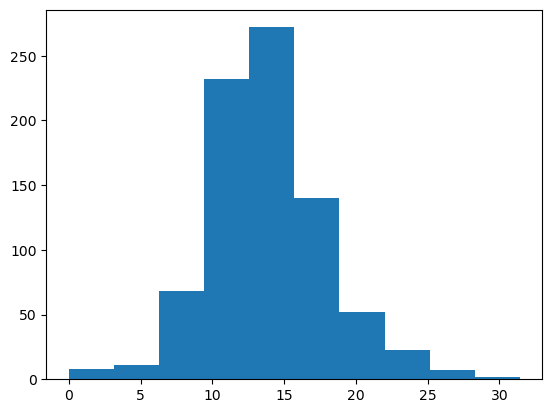

count    815.000000
mean      13.781071
std        4.152852
min        0.000000
25%       11.183854
50%       13.527581
75%       15.979849
max       31.414444
Name: NBA_PTS_36, dtype: float64

In [11]:
# Display distribution of NBA PTS/36
plt.hist(draft_df["NBA_PTS_36"])
plt.show()

# Show summary statistics for PTS/36
draft_df['NBA_PTS_36'].describe()

In [12]:
# Calculate proportion of players whose NBA PTS is not available (since never played in NBA)
draft_df['NBA_PTS_36'].isnull().mean()

0.09242761692650334

In [13]:
# fill in 0 for players without NBA experience
for c in ['NBA_PTS_36', 'NBA_G']:
    draft_df[c] = draft_df[c].fillna(0)

# Shrink PTS/36 towards 0 for players with that did not play much in NBA
draft_df['Adj_NBA_PTS_36'] = draft_df['NBA_PTS_36'] * (1 - np.exp(-draft_df['NBA_G'] / 100))

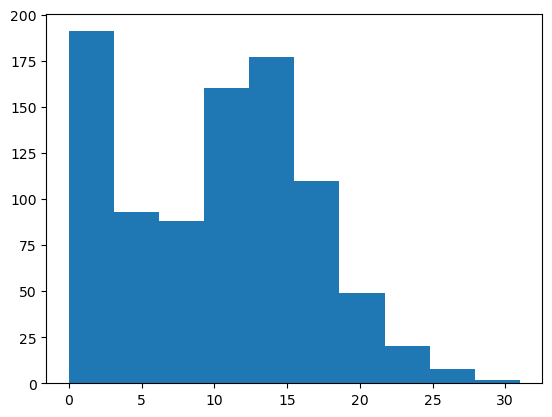

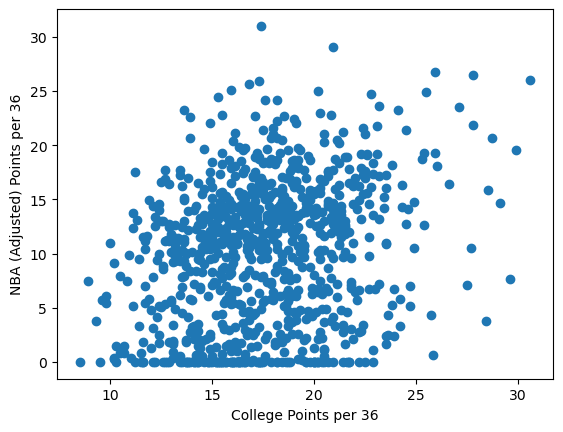

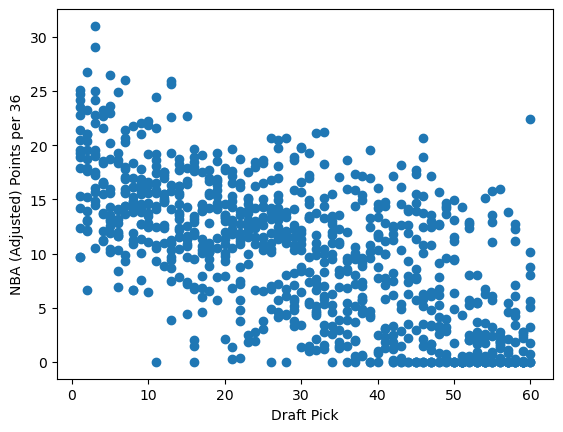

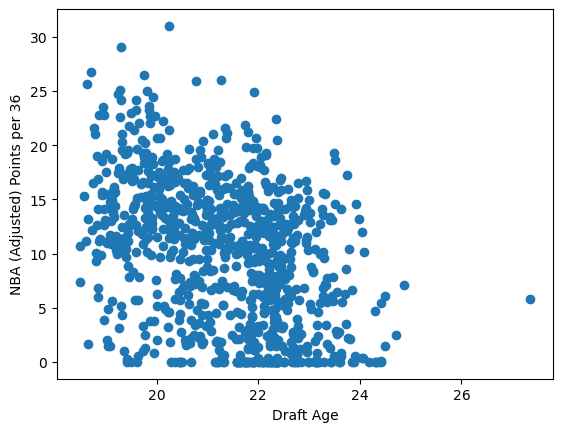

count    898.000000
mean      10.047755
std        6.561368
min        0.000000
25%        4.356655
50%       10.935590
75%       14.592829
max       31.000793
Name: Adj_NBA_PTS_36, dtype: float64

In [14]:
# Display new distribution of PTS/36
plt.hist(draft_df['Adj_NBA_PTS_36'])
plt.show()

# Relationship of pre-draft PTS/36 to NBA (adjusted) PTS/36
plt.scatter(draft_df['PTS'], draft_df['Adj_NBA_PTS_36'])
plt.xlabel("College Points per 36")
plt.ylabel("NBA (Adjusted) Points per 36")
plt.show()

# Relationship of draft pick with NBA adjusted PTS/36
plt.scatter(draft_df['Pick'], draft_df['Adj_NBA_PTS_36'])
plt.xlabel("Draft Pick")
plt.ylabel("NBA (Adjusted) Points per 36")
plt.show()

# Relationship of draft age with NBA adjusted PTS/36
plt.scatter(draft_df['Draft Age'], draft_df['Adj_NBA_PTS_36'])
plt.xlabel("Draft Age")
plt.ylabel("NBA (Adjusted) Points per 36")
plt.show()

# Summary statistics
draft_df['Adj_NBA_PTS_36'].describe()

## True Shooting

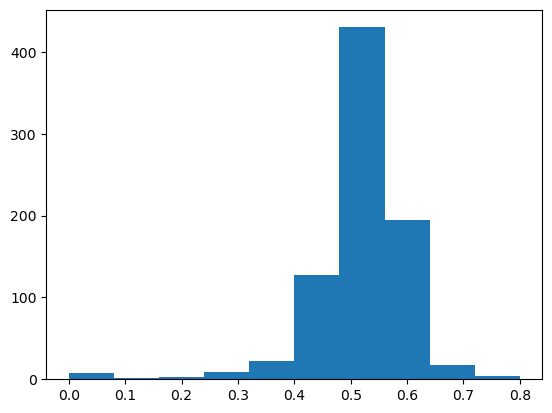

count    815.000000
mean       0.518976
std        0.084779
min        0.000000
25%        0.491203
50%        0.531254
75%        0.562343
max        0.800000
Name: NBA_TS%, dtype: float64

In [15]:
# Show distribution of True Shooting
plt.hist(draft_df['NBA_TS%'])
plt.show()

# Show summary statistics
draft_df['NBA_TS%'].describe()

In [16]:
# Calculate mean TS% for players with little NBA time
draft_df[draft_df['NBA_G'] <= 100]['NBA_TS%'].mean()

0.4510418091938401

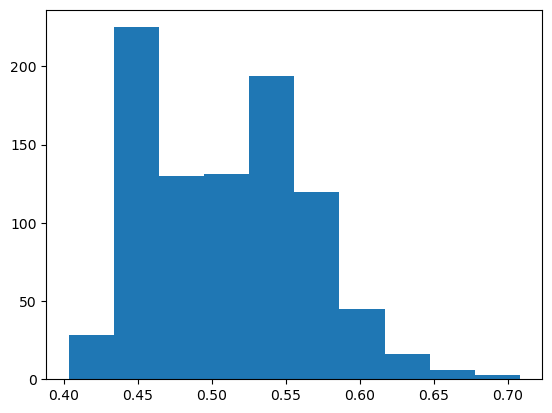

count    898.000000
mean       0.511087
std        0.054084
min        0.403272
25%        0.459426
50%        0.513840
75%        0.551139
max        0.708217
Name: Adj_NBA_TS%, dtype: float64

In [17]:
# Set the default assumed TS% for players without any NBA experience to the calculated average for players with low experience
DEFAULT_TSP = 0.45

# shrink TS% towards the default based on time in NBA
draft_df['NBA_TS%'] = draft_df['NBA_TS%'].fillna(DEFAULT_TSP)
draft_df['Adj_NBA_TS%'] = DEFAULT_TSP + (draft_df['NBA_TS%'] - DEFAULT_TSP) * (1 - np.exp(-draft_df['NBA_G'] / 100))

# Distributed of adjusted TS%
plt.hist(draft_df['Adj_NBA_TS%'])
plt.show()

# Summary statistics
draft_df['Adj_NBA_TS%'].describe()

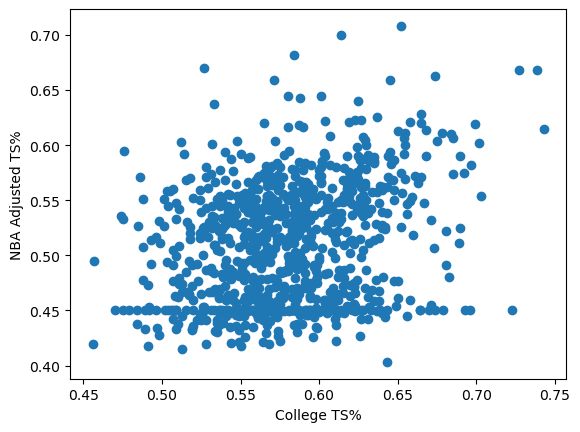

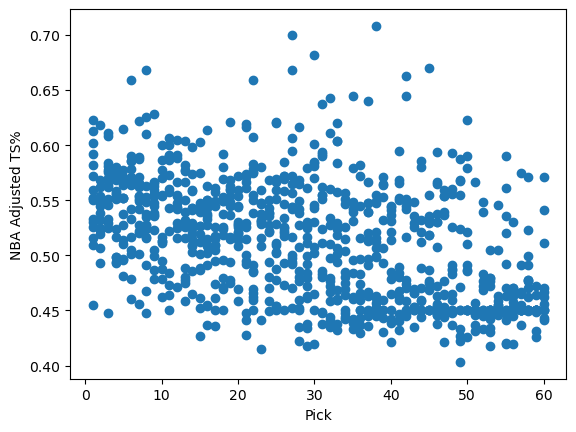

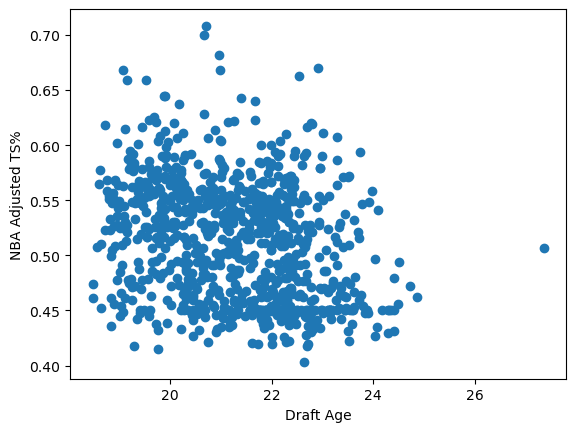

In [18]:
# relationship of college TS% to NBA adjusted TS%
plt.scatter(draft_df['TS%'], draft_df['Adj_NBA_TS%'])
plt.xlabel("College TS%")
plt.ylabel("NBA Adjusted TS%")
plt.show()

# relationship of draft pick to NBA adjusted TS%
plt.scatter(draft_df['Pick'], draft_df['Adj_NBA_TS%'])
plt.xlabel("Pick")
plt.ylabel("NBA Adjusted TS%")
plt.show()

# relationship of draft age to NBA adjusted TS%
plt.scatter(draft_df['Draft Age'], draft_df['Adj_NBA_TS%'])
plt.xlabel("Draft Age")
plt.ylabel("NBA Adjusted TS%")
plt.show()

# Predictor Matrix and Response Vectors

In [19]:
# create predictor matrix 
X = draft_df[predictor_vars]

# create points response vectors
y_pts = draft_df['Adj_NBA_PTS_36']
y_tsp = draft_df['Adj_NBA_TS%']

# Train Test Split

In [20]:
from sklearn.model_selection import train_test_split

# split the data into a training and a testing set
X_train, X_test, y_pts_train, y_pts_test, y_tsp_train, y_tsp_test = train_test_split(X, y_pts, y_tsp, 
                                                                                     test_size = 0.2, random_state = 23)

In [21]:
# store which indices belong to train set and which indices belong to test set
train_index = X_train.index
test_index = X_test.index

In [22]:
# see train and test set sizes
print(f"Train size: {len(X_train)}")
print(f"Test size: {len(X_test)}")

Train size: 718
Test size: 180


# Imputation and Scaling

In [23]:
# See which features have NA values
for p in predictor_vars:
    na_count = sum(draft_df[p].isnull())
    if na_count > 0:
        print(f"{p}: {na_count} NA values")

Wingspan: 231 NA values
USG%: 183 NA values
AST/USG: 183 NA values
PER: 413 NA values
OWS/40: 193 NA values
DWS/40: 193 NA values
WS/40: 193 NA values
OBPM: 423 NA values
DBPM: 423 NA values
BPM: 423 NA values
WS/Ht Ratio: 231 NA values
Wingspan_diff: 231 NA values
log_AST/USG: 183 NA values


In [24]:
# import imputation and scaling functions
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler

In [25]:
# run iterative imputation to fill in missing values
# cap the features at 10 in order to prevent overfitting
# increase tolerance in order to ensure convergence
# fit the imputer to the training data only
imp = IterativeImputer(random_state = 314, n_nearest_features = 10, tol = 0.02)
imp.fit(X_train)

IterativeImputer(n_nearest_features=10, random_state=314, tol=0.02)

In [26]:
# initialize scaler object
scaler = StandardScaler()


# get imputated values
X_temp = imp.transform(X_train)

# convert from np array to pd DataFrame
X_temp = toDF(X_temp, predictor_vars)

# recreate features after imputation
X_temp = features_after_imp(X_temp)


# fit the scaler to the training data only
scaler.fit(X_temp)

StandardScaler()

# PCA

In [27]:
from sklearn.decomposition import PCA

# get scaled training data
X_sc = scaler.transform(X_temp)
X_sc = toDF(X_sc, predictor_vars)

# initialize PCA object
pca = PCA()

# fit PCA on scaled and imputed training data
pca.fit(X_sc)

PCA()

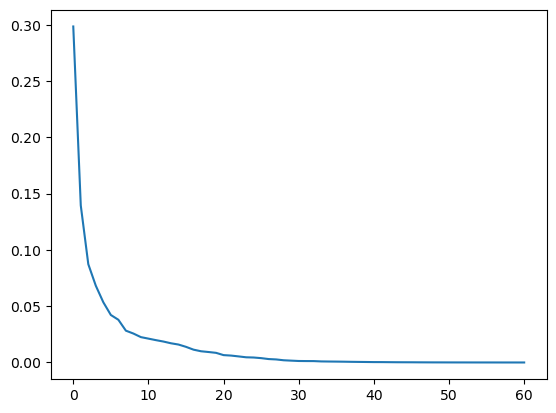

In [28]:
# plot how much each element explains the variance
plt.plot(list(range(len(pca.explained_variance_ratio_))), pca.explained_variance_ratio_)

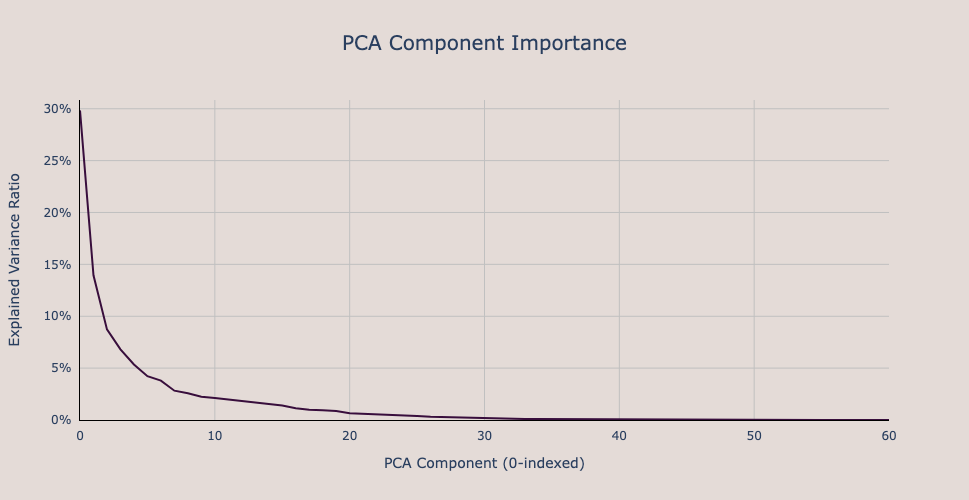

In [29]:
Y = pca.explained_variance_ratio_
# Y = np.cumsum(pca.explained_variance_ratio_)

f = go.Figure(data = [go.Scatter(x = list(range(len(Y))),
                                 y = Y,
                                 mode = 'lines',
                                 marker_color = MY_COLOR)])
f.update_layout(xaxis_title = "PCA Component (0-indexed)",
                yaxis_title = "Explained Variance Ratio",
                title = "PCA Component Importance",
                yaxis_range = [0, np.max(Y) + 0.01])
f.update_yaxes(tickformat = ".0%")
cleanFigure(f, grid = True, size = 500)
f

In [30]:
# fit the PCA and return only N_COMPONENTS components
# collapses feature dimensionality from 50+ to N_COMPONENTS
N_COMPONENTS = 15

pca = PCA(n_components = N_COMPONENTS)
pca.fit(X_sc)

PCA(n_components=15)

In [31]:
pca_df = pd.DataFrame(pca.components_)
pca_df.columns = predictor_vars
pca_df

Pick    Height  Wingspan    Weight  Draft Age         G        MP  \
0   0.035267 -0.195682 -0.206409 -0.186739   0.022276  0.002305  0.115106   
1  -0.121253 -0.020252 -0.039164  0.015009   0.030304  0.048089  0.146600   
2  -0.138009 -0.032226 -0.024086 -0.018761  -0.113696 -0.003620 -0.067910   
3  -0.192098  0.035780  0.000228 -0.039581  -0.075707  0.112201 -0.064804   
4  -0.342790  0.009447  0.042509 -0.022873  -0.325197 -0.025601  0.021420   
5  -0.027665  0.093054 -0.099501 -0.021525  -0.074241 -0.088989 -0.300340   
6   0.027731 -0.190588  0.083176  0.045442   0.068055 -0.039249 -0.134269   
7   0.065882  0.079129 -0.012615 -0.127649   0.109677 -0.148590 -0.043732   
8   0.049985 -0.050515  0.001933 -0.147705   0.010182 -0.196717  0.073184   
9  -0.004216  0.010128  0.085092 -0.032621  -0.154696 -0.124445 -0.038153   
10 -0.029891 -0.081582 -0.042781  0.001675  -0.187677  0.108719 -0.230914   
11 -0.021863  0.007517 -0.051780  0.004537   0.143575 -0.070289  0.261158   
12  0.001905  0.163133  0.129562  0.383972   0.111960 -0.165821  0.028135   
13  0.041531  0.121069  0.006671  0.282740  -0.091986 -0.086596 -0.116865   
14  0.009401  0.038206  0.045054  0.020674  -0.041337 -0.572259  0.103269   

         3PM       3PA       3P%  ...  log_AST/TO    log_MP  log_pick  \
0   0.177211  0.184597  0.180144  ...    0.196620  0.107753  0.037512   
1   0.029554  0.013528  0.021203  ...    0.043207  0.146566 -0.139050   
2  -0.187556 -0.169252 -0.156005  ...    0.117322 -0.064714 -0.153509   
3   0.124934  0.094657  0.124757  ...    0.084594 -0.058566 -0.204417   
4   0.078801  0.105482  0.088889  ...   -0.116447  0.020133 -0.372218   
5   0.064964  0.055253  0.033894  ...   -0.100778 -0.310586 -0.023889   
6   0.120062  0.115204  0.107613  ...   -0.064116 -0.135757  0.026710   
7   0.085334  0.117874  0.048541  ...   -0.018944 -0.040132  0.100812   
8   0.068783  0.053977  0.010128  ...   -0.101235  0.065267  0.047721   
9   0.086399  0.084080  0.025364  ...   -0.019912 -0.041580  0.030706   
10 -0.011989 -0.002732 -0.087278  ...    0.128085 -0.248947 -0.007373   
11 -0.015225 -0.014977 -0.094559  ...   -0.060743  0.270562 -0.056194   
12  0.054975  0.043900  0.022536  ...    0.056485  0.028460 -0.008600   
13  0.102271  0.098952  0.108661  ...    0.019518 -0.110550  0.041146   
14  0.065344  0.047131  0.015967  ...    0.027162  0.103050 -0.049252   

    PTS_x_AST  BLK_x_STL  3P%_x_PTS  PTS_x_log_pick  AST_x_log_pick  \
0    0.176721  -0.144280   0.162269        0.047770        0.183578   
1    0.135303   0.029338   0.107536        0.037617       -0.011058   
2    0.168258   0.131980  -0.180882       -0.223586        0.132040   
3   -0.069361   0.101297   0.068970       -0.271473       -0.115114   
4   -0.005816  -0.009683   0.113929       -0.281441       -0.211433   
5    0.062670  -0.114586   0.074363        0.033656       -0.007034   
6    0.026776   0.057779   0.121196        0.058092        0.004109   
7    0.000785   0.310798   0.075475        0.143832        0.034703   
8   -0.020157   0.179486   0.017995        0.023451       -0.012746   
9    0.117635   0.159921   0.080611        0.128878        0.080032   
10   0.010946  -0.093143  -0.063047        0.023225       -0.004882   
11  -0.046167  -0.039677  -0.096664       -0.061005       -0.061326   
12   0.046831  -0.120827   0.020699       -0.019748        0.045982   
13   0.029113   0.067922   0.080081        0.013503        0.045537   
14  -0.013494   0.004032   0.006147       -0.070570       -0.026650   

    Height_x_AST  inv_pick  
0       0.186102 -0.029395  
1       0.055745  0.123255  
2       0.230585  0.129978  
3      -0.033360  0.166910  
4      -0.043771  0.306639  
5       0.019549  0.014876  
6      -0.010095 -0.015646  
7      -0.023333 -0.129197  
8      -0.039090 -0.034486  
9       0.071993 -0.051406  
10     -0.029922 -0.008194  
11     -0.021701  0.074339  
12      0.073194  0.015107  
13      0.056884 -0.023499  
14     -0.005175  0.118553  

[15 

In [32]:
def plot_pca_comp(pca_df, comp):
    """
    Returns a plotly figure displaying a bar chart of the 6 most important positive and negative features
        for a given component of the pca dataframe
    """
    if comp >= len(pca_df):
        return None
    vec = pca_df.loc[comp]
    top6 = vec.sort_values(ascending = False).head(6)
    bottom6 = vec.sort_values(ascending = False).tail(6)
    index = top6.index.tolist() + bottom6.index.tolist()
    val = top6.values.tolist() + bottom6.values.tolist()
    index.reverse()
    val.reverse()
    f = go.Figure(data = [go.Bar(y = index, x = val, orientation = 'h',
                                 marker = dict(color = MY_COLOR, line = dict(color = 'black', width = 1)))])
    f.add_vline(x = 0)
    f.update_layout(xaxis_title = "Magnitude",
                    yaxis_title = "Feature",
                    title = f"PCA Component {comp} Breakdown")
    cleanFigure(f, grid = True, size = 600)
    return f

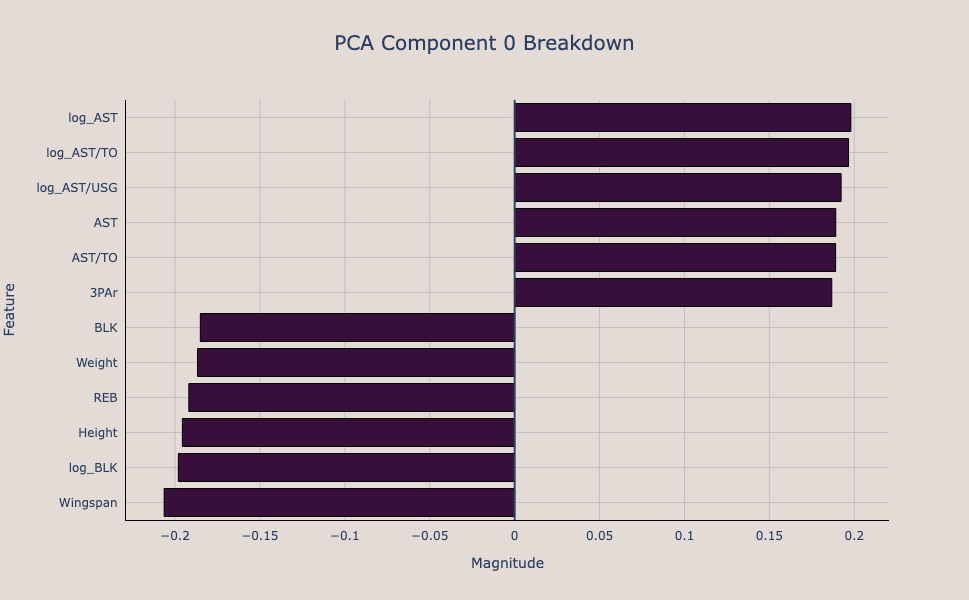

In [33]:
plot_pca_comp(pca_df, 0)

# All Preprocessing

In [34]:
def createX(df, predictors, imp, scaler, pca, apply_pca = True):
    """
    Creates the design matrix from the original data, list of predictors, and imputer / scaler / pca objects
    
    Parameters
    ----------
    df : pd.DataFrame
        dataframe containing at least all relevant predictor variables
    predictors : list
        list of predictor variables to be extracted from the dataframe
    imp : sklearn imputer object
        fitted imputer object to impute missing values
    scaler : sklearn scaler object
        fitted scaler object to standardize the input columns
    pca : sklearn pca object
        fitted pca object to reduce dimensionality
    apply_pca : bool
        Decide whether to reduce feature dimensionality or to stop after scaling
        
    Returns
    -------
    pd.DataFrame
        design matrix that contains only the relevant predictors and is imputed, scaled, and has reduced dimensionality
    """
    # extract predictor variables
    X = df[predictors]
    
    # impute missing values
    X = imp.transform(X)
    
    # fix potential errors with AST/USG and log transform it
    X = toDF(X, predictors)
    X['AST/USG'] = np.where(X['AST/USG'] < 0, 0, X['AST/USG'])
    X['log_AST/USG'] = np.log(X['AST/USG'] + 1)
    
    # scale the predictors
    X = scaler.transform(X)
    
    if apply_pca:
        # convert to dataframe
        X = toDF(X, predictors)

        # apply pca
        X = pca.transform(X)

        # return data as a dataframe
        X = toDF(X, [f"pca{i}" for i in range(X.shape[1])])
        return X
    
    else:
        return toDF(X, predictors)

In [35]:
# create relevant design matrices
# ultimately decided not to apply PCA and pursue a different method of feature space reduction 
APPLY_PCA = False

X = createX(draft_df, predictor_vars, imp, scaler, pca, apply_pca = APPLY_PCA)
X_train = createX(X_train, predictor_vars, imp, scaler, pca, apply_pca = APPLY_PCA)
X_test = createX(X_test, predictor_vars, imp, scaler, pca, apply_pca = APPLY_PCA)
X_r = createX(recent_df, predictor_vars, imp, scaler, pca, apply_pca = APPLY_PCA)
X_24 = createX(draft24, predictor_vars, imp, scaler, pca, apply_pca = APPLY_PCA)

In [36]:
# restore correct indices for train/test data
X_train.index = train_index
X_test.index = test_index

# Modeling Functions

In [37]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from scipy.stats import uniform

In [38]:
# function to fit a specific model and optimize hyperparameters 
def fitModel(X_train, X_test, y_train, y_test, model, grid, cv, classifier = True, verbose = True, grid_search = True):
    loss_str = 'neg_log_loss' if classifier else 'neg_mean_squared_error'
    loss_fxn = log_loss if classifier else mean_squared_error
    if grid_search:
        gs = GridSearchCV(model, grid, scoring = loss_str, cv = cv, verbose = 0)
    else:
        gs = RandomizedSearchCV(model, grid, scoring = loss_str, cv = cv, verbose = 0,
                                n_iter = 100, random_state = 10)
    gs.fit(X_train, y_train)
    clf = gs.best_estimator_
    if verbose:
        print(f"Best parameters: {gs.best_params_}")
    val_loss = -1 * gs.best_score_
    if classifier:
        train_pred = clf.predict_proba(X_train)
        test_pred = clf.predict_proba(X_test)
    else:
        train_pred = clf.predict(X_train)
        test_pred = clf.predict(X_test)
    train_loss = loss_fxn(y_train, train_pred)
    test_loss = loss_fxn(y_test, test_pred)
    if verbose:
        print(f"Train Loss: {train_loss}")
        print(f"Validation Loss: {val_loss}")
    loss = {'Train' : train_loss, 'Validation' : val_loss, 'Test' : test_loss}
    return clf, loss
    
# function to fit a variety of models while optimizing hyperparameters
# models parameter should be dictionary mapping a string to a dictionary including the model, grid, and grid_search (boolean)
def fitManyModels(models, X_train, X_test, y_train, y_test, cv, classifier = True):
    results = {}
    for name, info in models.items():
        m = info['model']
        g = info['grid']
        grid_search = info['grid_search']
        print(f"----------{name.upper()}----------")
        clf, losses = fitModel(X_train, X_test, y_train, y_test,
                               m, g, cv, classifier = classifier, verbose = True, grid_search = grid_search)
        results[name] = {'model' : clf, 'loss' : losses}
    return results

In [39]:
# function to display coefficient values for a LINEAR model
def create_feat_df(linear_model):
    feat_df = pd.DataFrame({
        'Feature' : linear_model.feature_names_in_,
        'Coef' : linear_model.coef_
    })
    return feat_df[feat_df['Coef'] != 0].sort_values('Coef', ascending = False)

# function to reduce feature space based on coefficients of a fitted linear model
# if n >= 1: will keep the n features with the highest absolute value coefficients
# if n between 0 and 1: will keep any features with an absolute coefficient value at least n% of the max absolute coefficient
def trim_predictors(linear_model, n = 10):
    f_df = create_feat_df(linear_model)
    f_df['abs'] = np.abs(f_df['Coef'])
    if n >= 1:
        n = min(n, len(f_df))
        new_feats = f_df.sort_values('abs', ascending = False)['Feature'].head(n).tolist()
    else:
        max_abs = np.max(f_df['abs'])
        new_feats = f_df[f_df['abs'] >= n * max_abs].sort_values('abs', ascending = False)['Feature'].tolist()
    return new_feats

In [40]:
class Double_Lasso():
    def __init__(self, random_state = 123):
        self.model = Lasso(random_state = random_state)
        self.loss = {'train' : np.nan, 'validation' : np.nan, 'test' : np.nan}
        self.features = []
        self.isFit = False
        
    def __repr__(self):
        return f"Double_Lasso(model = {self.model})"
    
    def fit_all(self, X_train, X_test, y_train, y_test, grid, cv, n):
        if self.isFit:
            raise AssertionError("The model has already been fit!")
        print("Fitting initial model...")
        first, first_loss = fitModel(X_train, X_test, y_train, y_test, self.model, grid, cv,
                                     classifier = False, verbose = True, grid_search = True)
        reduced = trim_predictors(first, n = n)
        self.features = reduced
        print("\nFitting reduced model...")
        final, final_loss = fitModel(X_train[reduced], X_test[reduced], y_train, y_test, self.model, grid, cv,
                                     classifier = False, verbose = True, grid_search = True)
        self.model = final
        self.loss = final_loss
        self.isFit = True
        
    def display_features(self):
        if not self.isFit:
            raise AssertionError("The model has not been fit yet! First call fit_all() method!")
        return create_feat_df(self.model)
    
    def predict(self, X):
        if not self.isFit:
            raise AssertionError("The model has not been fit yet! First call fit_all() method!")
        return self.model.predict(X[self.features])
    
    def mse(self, X, y):
        yhat = self.predict(X)
        return mean_squared_error(y, yhat)
    
    def score(self, X, y):
        yhat = self.predict(X)
        rss = ((y - yhat)**2).sum()
        tss = ((y - y.mean())**2).sum()
        return 1 - rss/tss
    
    def full_predict(self, df, X, y = None):
        if not self.isFit:
            raise AssertionError("The model has not been fit yet! First call fit_all() method!")
        df = add_predictions(df, X[self.features], self.model, classifier = False)
        if y is not None:
            df['Real'] = y
        df = df.sort_values(0, ascending = False)
        df = df.rename(columns = {0 : 'Predicted'})
        return df
    
    def get_loss(self):
        return self.loss
    
    def get_features(self):
        return self.features

# Modeling - Scoring

In [41]:
# create (5-fold) cross validation object
cv = KFold(n_splits = 5, random_state = 314, shuffle = True)

# define models
models_pts = {
    'Ridge' : {'model' : Ridge(random_state = 123),
               'grid' : {'alpha' : np.arange(10,100,5)},
               # 'grid' : {'alpha' : np.arange(50, 150, 5)},
               'grid_search' : True},
    'LASSO' : {'model' : Lasso(random_state = 123),
               'grid' : {'alpha' : np.arange(0.01, 0.25, 0.01)},
               # 'grid' : {'alpha' : np.arange(0.002, 0.020, 0.001)},
               'grid_search' : True},
    # 'Random Forest' : {'model' : RandomForestRegressor(random_state = 123),
    #                    'grid' : {'max_depth' : np.arange(2, 12, 2),
    #                              'min_samples_leaf' : [5, 10, 20],
    #                              # 'max_features' : [0.25, 0.5, 0.75, 1],
    #                              'ccp_alpha' : [0.0, 0.01, 0.1]},
    #                    'grid_search' : True},
    'MLP' : {'model' : MLPRegressor(random_state = 123, shuffle = True, max_iter = 1000, n_iter_no_change = 5,
                                    early_stopping = True),
             'grid' : {'activation' : ['relu', 'logistic'],
                       'hidden_layer_sizes' : [(x,) for x in np.arange(2,12,1)] + [(y,y//2) for y in np.arange(2,12,1)],
                       'learning_rate_init' : [0.1, 0.01],
                       'alpha' : uniform(loc = 0.0, scale = 1.0)},
             'grid_search' : False},
    'SVM' : {'model' : SVR(),
             'grid' : {'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
                       'C' : np.arange(0.02, 0.20, 0.02)},
             'grid_search' : True},
    # 'XGB' : {'model' : XGBRegressor(random_state = 123),
    #          'grid' : {'n_estimators' : [100, 200, 500, 1000],
    #                    'max_depth' : np.arange(3, 11, 1),
    #                    'learning_rate' : [1e-4, 1e-3, 0.01, 0.1],
    #                    'subsample' : uniform(loc = 0.1, scale = 0.9),
    #                    'colsample_bytree' : uniform(loc = 0.1, scale = 0.9),
    #                    'colsample_bylevel' : uniform(loc = 0.1, scale = 0.9),
    #                    'reg_alpha' : uniform(loc = 0, scale = 1),
    #                    'reg_lambda' : uniform(loc = 0, scale = 1)},
    #          'grid_search' : False}
}

# fit the PTS/36 models
pts_results = fitManyModels(models_pts, X_train, X_test, y_pts_train, y_pts_test, cv = cv, classifier = False)

----------RIDGE----------
Best parameters: {'alpha': 95}
Train Loss: 22.24745794409333
Validation Loss: 24.55712309574688
----------LASSO----------


/Users/ayushbatra/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.379e+00, tolerance: 2.521e+00



Best parameters: {'alpha': 0.18000000000000002}
Train Loss: 22.89714264300735
Validation Loss: 23.985047939330773
----------MLP----------
Best parameters: {'activation': 'logistic', 'alpha': 0.029179555725059814, 'hidden_layer_sizes': (11,), 'learning_rate_init': 0.01}
Train Loss: 21.006275249745805
Validation Loss: 27.044691770540787
----------SVM----------
Best parameters: {'C': 0.02, 'kernel': 'linear'}
Train Loss: 23.089522127948527
Validation Loss: 25.09856736924623


In [42]:
pts_lasso = Double_Lasso()
pts_lasso.fit_all(X_train, X_test, y_pts_train, y_pts_test, 
                  grid = models_pts['LASSO']['grid'], cv = cv, n = 0.05)

Fitting initial model...


/Users/ayushbatra/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.379e+00, tolerance: 2.521e+00



Best parameters: {'alpha': 0.18000000000000002}
Train Loss: 22.89714264300735
Validation Loss: 23.985047939330773

Fitting reduced model...
Best parameters: {'alpha': 0.01}
Train Loss: 22.863777920045926
Validation Loss: 23.21522027112113


In [43]:
# Fit TS% models
models_tsp = {
    'Ridge' : {'model' : Ridge(random_state = 123),
               'grid' : {'alpha' : np.arange(10,100,5)},
               'grid_search' : True},
    'LASSO' : {'model' : Lasso(random_state = 123),
               'grid' : {'alpha' : np.arange(0.0001, 0.0030, 0.0001)},
               'grid_search' : True},
    # 'Random Forest' : {'model' : RandomForestRegressor(random_state = 123),
    #                    'grid' : {'max_depth' : np.arange(1, 10, 1),
    #                              'min_samples_split' : [5, 10, 20],
    #                              'max_features' : [0.25, 0.5, 0.75, 1]},
    #                    'grid_search' : True},
    'MLP' : {'model' : MLPRegressor(random_state = 123, shuffle = True, max_iter = 1000, n_iter_no_change = 5),
             'grid' : {'activation' : ['relu', 'logistic'],
                       'hidden_layer_sizes' : [(x,) for x in np.arange(2,10,2)],
                       'learning_rate_init' : [0.1, 0.01]},
             'grid_search' : True},
    'SVM' : {'model' : SVR(),
             'grid' : {'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
                       'C' : np.arange(0.02, 0.20, 0.02)},
             'grid_search' : True},
    # 'XGB' : {'model' : XGBRegressor(random_state = 123),
    #          'grid' : {'n_estimators' : [100, 200, 500, 1000],
    #                    'max_depth' : np.arange(3, 11, 1),
    #                    'learning_rate' : [1e-4, 1e-3, 0.01, 0.1],
    #                    'subsample' : uniform(loc = 0.1, scale = 0.9),
    #                    'colsample_bytree' : uniform(loc = 0.1, scale = 0.9),
    #                    'colsample_bylevel' : uniform(loc = 0.1, scale = 0.9),
    #                    'reg_alpha' : uniform(loc = 0, scale = 1),
    #                    'reg_lambda' : uniform(loc = 0, scale = 1)},
    #          'grid_search' : False}
}

tsp_results = fitManyModels(models_tsp, X_train, X_test, y_tsp_train, y_tsp_test, cv = cv, classifier = False)

----------RIDGE----------
Best parameters: {'alpha': 90}
Train Loss: 0.0019064669208546088
Validation Loss: 0.0021210064414428475
----------LASSO----------


/Users/ayushbatra/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.438e-03, tolerance: 1.730e-04

/Users/ayushbatra/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.170e-04, tolerance: 1.687e-04

/Users/ayushbatra/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.113e-04, tolerance: 1.707e-04



Best parameters: {'alpha': 0.0011}
Train Loss: 0.0019618355131055805
Validation Loss: 0.002123916597737876
----------MLP----------
Best parameters: {'activation': 'logistic', 'hidden_layer_sizes': (4,), 'learning_rate_init': 0.01}
Train Loss: 0.0019777748698023194
Validation Loss: 0.0023074575452264588
----------SVM----------
Best parameters: {'C': 0.06, 'kernel': 'sigmoid'}
Train Loss: 0.03925859746060462
Validation Loss: 0.0027779123857243353


In [44]:
tsp_lasso = Double_Lasso()
tsp_lasso.fit_all(X_train, X_test, y_tsp_train, y_tsp_test, 
                  grid = models_tsp['LASSO']['grid'], cv = cv, n = 0.1)

Fitting initial model...


/Users/ayushbatra/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.438e-03, tolerance: 1.730e-04

/Users/ayushbatra/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.170e-04, tolerance: 1.687e-04

/Users/ayushbatra/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.113e-04, tolerance: 1.707e-04



Best parameters: {'alpha': 0.0011}
Train Loss: 0.0019618355131055805
Validation Loss: 0.002123916597737876

Fitting reduced model...
Best parameters: {'alpha': 0.0001}
Train Loss: 0.0019770977623694724
Validation Loss: 0.002066213676981221


In [45]:
# display coefficients for final PTS model
pts_lasso.display_features()

Feature      Coef
2        BPM  0.760435
3        PTS  0.615072
6     log_MP  0.325700
5     na_bpm -0.376350
4   Wingspan -0.514861
1  Draft Age -1.115724
0       Pick -3.297990

In [46]:
# display coefficients for final TS% model
tsp_lasso.display_features()

Feature      Coef
6        TS%  0.006707
4        BPM  0.004724
7     log_MP  0.004680
3       eFG%  0.004528
8          C  0.003857
9         TO -0.003900
5     na_bpm -0.004663
2        3P% -0.006530
1  Draft Age -0.009239
0       Pick -0.016904

In [47]:
pts_lasso.full_predict(draft_df, X, y_pts).head(10)

Name  Year Draft Team          Team Position  Pick  Predicted  \
787  Zion Williamson  2019         NO          Duke       PF     1  22.603919   
191  Michael Beasley  2008        MIA  Kansas State    SF/PF     2  21.632885   
360     Kyrie Irving  2011        CLE          Duke       PG     1  20.959688   
737       Trae Young  2018        ATL      Oklahoma       PG     5  20.184670   
788        Ja Morant  2019        MEM  Murray State       PG     2  19.601486   
681   Markelle Fultz  2017        PHI    Washington       PG     1  19.559217   
252    Stephen Curry  2009         GS      Davidson       PG     7  19.551980   
139     Kevin Durant  2007        OKC         Texas       SF     2  19.282914   
246    Blake Griffin  2009        LAC      Oklahoma       PF     1  19.273758   
194       Kevin Love  2008        MIN          UCLA       PF     5  19.173578   

          Real  
787  23.483600  
191  19.551952  
360  24.675634  
737  26.454162  
788  23.213501  
681  14.214695  
252  26.036364  
139  26.717600  
246  21.416473  
194  20.206690

In [48]:
# TSP predictions for players from 2004-2020
tsp_lasso.full_predict(draft_df, X, y_tsp).head(10)

Name  Year Draft Team        Team Position  Pick  \
793        Jaxson Hayes  2019         NO       Texas        C     8   
413       Anthony Davis  2012         NO    Kentucky     PF/C     1   
787     Zion Williamson  2019         NO        Duke       PF     1   
577       Jahlil Okafor  2015        PHI        Duke        C     3   
733       DeAndre Ayton  2018        PHX     Arizona        C     1   
41         Andrew Bogut  2005        MIL        Utah        C     1   
473        Nerlens Noel  2013        PHI    Kentucky        C     6   
138           Greg Oden  2007        POR  Ohio State        C     1   
845      Onyeka Okongwu  2020        ATL         USC     PF/C     6   
575  Karl-Anthony Towns  2015        MIN    Kentucky        C     1   

     Predicted      Real  
793   0.617529  0.668283  
413   0.612756  0.591703  
787   0.606601  0.602279  
577   0.596088  0.562465  
733   0.593939  0.613154  
41    0.590707  0.550165  
473   0.589190  0.578670  
138   0.588965  0.552409  
845   0.588886  0.658847  
575   0.588005  0.622851

In [49]:
# PTS predictions for players from 2021-2023
pts_lasso.full_predict(recent_df, X_r).head(10)

Name  Year Draft Team            Team Position  Pick  \
61         Jabari Smith  2022        HOU          Auburn       PF     3   
60        Chet Holmgren  2022        OKC         Gonzaga        C     2   
62        Keegan Murray  2022        SAC            Iowa       PF     4   
1           Evan Mobley  2021        CLE             USC        C     3   
116      Brandon Miller  2023        CHA         Alabama       SF     2   
0       Cade Cunningham  2021        DET  Oklahoma State       PG     1   
59       Paolo Banchero  2022        ORL            Duke       PF     1   
64   Bennedict Mathurin  2022        IND         Arizona       SG     6   
3           Jalen Suggs  2021        ORL         Gonzaga    PG/SG     5   
118       Amen Thompson  2023        HOU  Overtime Elite    SG/PG     4   

     Predicted  
61   18.728089  
60   18.588037  
62   18.215570  
1    18.187033  
116  18.123387  
0    17.928397  
59   17.080789  
64   16.664921  
3    16.632914  
118  16.551676

In [50]:
# TS% predictions for players from 2021-2023
tsp_lasso.full_predict(recent_df, X_r).head(10)

Name  Year Draft Team               Team Position  Pick  \
72      Mark Williams  2022        CHA               Duke        C    15   
60      Chet Holmgren  2022        OKC            Gonzaga        C     2   
126  Dereck Lively II  2023        DAL               Duke        C    12   
1         Evan Mobley  2021        CLE                USC        C     3   
14     Alperen Şengün  2021        HOU  Beşiktaş (Turkey)        C    16   
70        Jalen Duren  2022        DET            Memphis        C    13   
79     Walker Kessler  2022        MIN             Auburn        C    22   
62      Keegan Murray  2022        SAC               Iowa       PF     4   
6        Franz Wagner  2021        ORL           Michigan       SF     8   
73         AJ Griffin  2022        ATL               Duke       SF    16   

     Predicted  
72    0.602231  
60    0.592111  
126   0.590171  
1     0.587621  
14    0.578312  
70    0.572106  
79    0.566660  
62    0.564616  
6     0.556486  
73    0.554078

In [51]:
# PTS predictions for 2024 prospects
pts_lasso.full_predict(draft24, X_24).head(10)

Name  Year  Draft Team               Team Position  Pick  \
1        Reed Sheppard  2024         NaN           Kentucky    PG/SG   3.4   
8       Rob Dillingham  2024         NaN           Kentucky       PG   8.8   
6      Donovan Clingan  2024         NaN              UConn        C   3.8   
0         Nikola Topić  2024         NaN  Red Star (Serbia)       PG   8.4   
5       Stephon Castle  2024         NaN              UConn    PG/SG   4.6   
7        Dalton Knecht  2024         NaN          Tennessee       SF   7.4   
3       Alexandre Sarr  2024         NaN        Perth (NBL)     PF/C   3.0   
2   Zaccharie Risacher  2024         NaN  JL Bourg (France)       SF   3.2   
12        Devin Carter  2024         NaN         Providence       PG  10.6   
13        Jared McCain  2024         NaN               Duke    PG/SG  14.4   

    Predicted  
1   17.909031  
8   17.128392  
6   16.992793  
0   16.503486  
5   15.768053  
7   15.543308  
3   15.530462  
2   15.324127  
12  15.224778  
13  15.013486

In [52]:
# TS% predictions for 2024 prospects
tsp_lasso.full_predict(draft24, X_24).head(10)

Name  Year  Draft Team               Team Position  Pick  \
6   Donovan Clingan  2024         NaN              UConn        C   3.8   
25        Zach Edey  2024         NaN             Purdue        C  19.4   
1     Reed Sheppard  2024         NaN           Kentucky    PG/SG   3.4   
21       Yves Missi  2024         NaN             Baylor        C  22.0   
18      Kel'el Ware  2024         NaN            Indiana        C  21.8   
11    Cody Williams  2024         NaN           Colorado       SF  10.8   
13     Jared McCain  2024         NaN               Duke    PG/SG  14.4   
3    Alexandre Sarr  2024         NaN        Perth (NBL)     PF/C   3.0   
5    Stephon Castle  2024         NaN              UConn    PG/SG   4.6   
0      Nikola Topić  2024         NaN  Red Star (Serbia)       PG   8.4   

    Predicted  
6    0.596052  
25   0.573670  
1    0.571679  
21   0.562706  
18   0.558886  
11   0.544226  
13   0.544096  
3    0.542375  
5    0.542121  
0    0.539825

In [53]:
print(f"Points Model Test Set Score: {pts_lasso.score(X_test, y_pts_test)}")
print(f"TS% Model Test Set Score: {tsp_lasso.score(X_test, y_tsp_test)}")

Points Model Test Set Score: 0.509573615101255
TS% Model Test Set Score: 0.27414097486967126


# EDA - Creation

## Passing

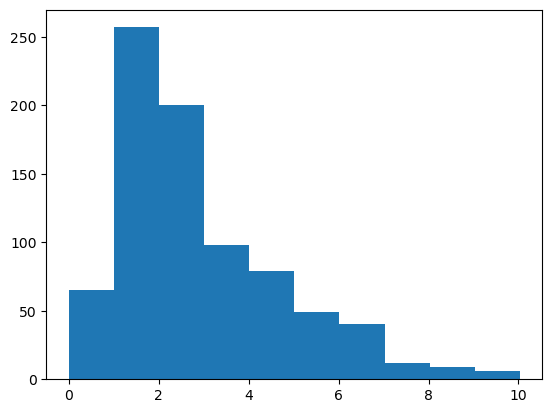

count    815.000000
mean       2.911590
std        1.853924
min        0.000000
25%        1.594473
50%        2.310811
75%        3.926764
max       10.030109
Name: NBA_AST_36, dtype: float64

In [54]:
# Distribution of assists
plt.hist(draft_df["NBA_AST_36"])
plt.show()

# summary statistics
draft_df['NBA_AST_36'].describe()

In [55]:
# fill in 0 for assists for players who haven't played in NBA
draft_df['NBA_AST_36'] = draft_df['NBA_AST_36'].fillna(0)

# shrink assist values towards 0 based on time in NBA
draft_df['Adj_NBA_AST_36'] = draft_df['NBA_AST_36'] * (1 - np.exp(-draft_df['NBA_G'] / 100))

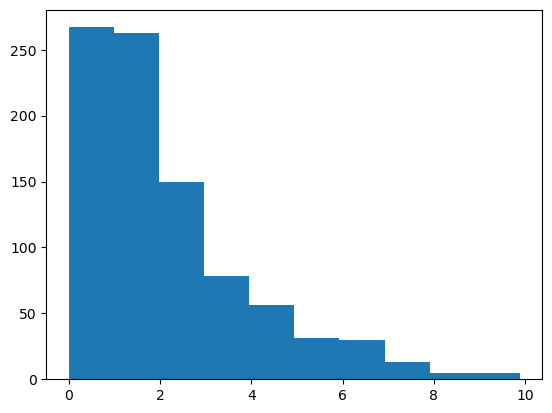

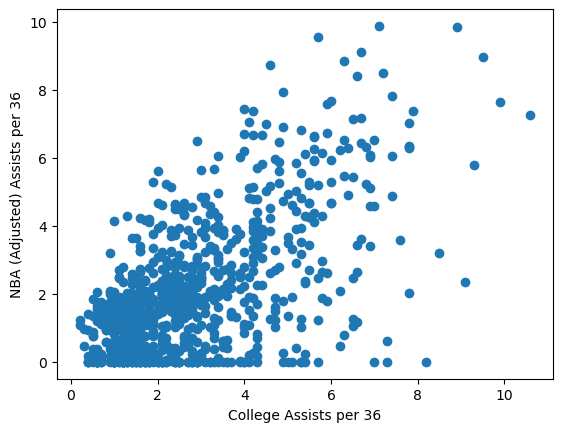

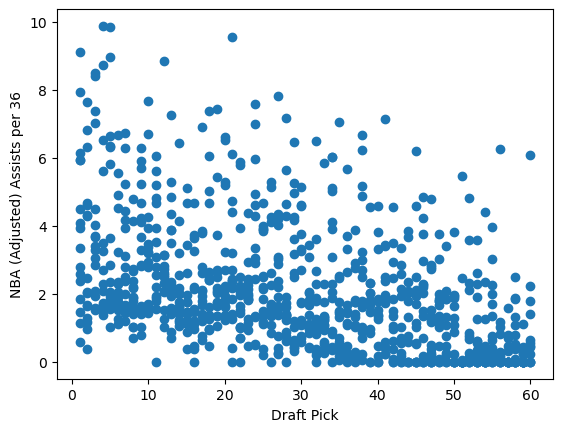

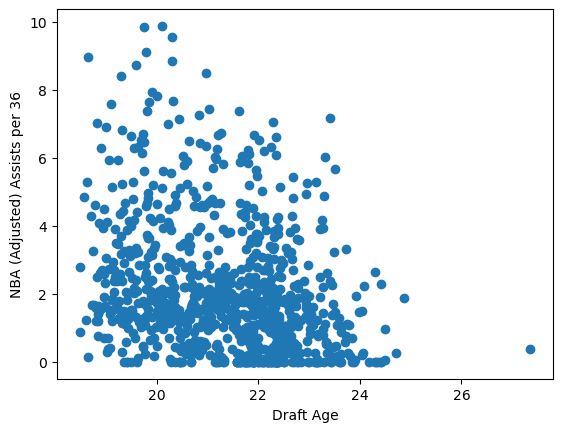

count    898.000000
mean       2.112306
std        1.896640
min        0.000000
25%        0.703573
50%        1.674345
75%        2.862835
max        9.885094
Name: Adj_NBA_AST_36, dtype: float64

In [56]:
# Distribution for adjusted assists
plt.hist(draft_df['Adj_NBA_AST_36'])
plt.show()

# Relationship between college AST/36 and NBA AST/36
plt.scatter(draft_df['AST'], draft_df['Adj_NBA_AST_36'])
plt.xlabel("College Assists per 36")
plt.ylabel("NBA (Adjusted) Assists per 36")
plt.show()

# Relationship between draft pick and NBA assists
plt.scatter(draft_df['Pick'], draft_df['Adj_NBA_AST_36'])
plt.xlabel("Draft Pick")
plt.ylabel("NBA (Adjusted) Assists per 36")
plt.show()

# Relationship between draft age and NBA assists
plt.scatter(draft_df['Draft Age'], draft_df['Adj_NBA_AST_36'])
plt.xlabel("Draft Age")
plt.ylabel("NBA (Adjusted) Assists per 36")
plt.show()

# summary statistics for response
draft_df['Adj_NBA_AST_36'].describe()

## Turnover Rate

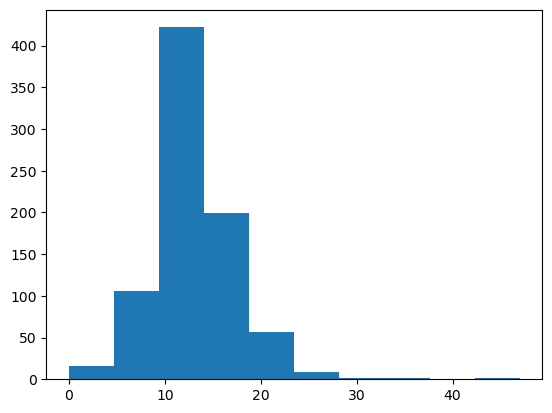

count    815.000000
mean      13.054604
std        4.611815
min        0.000000
25%       10.440863
50%       12.561543
75%       15.157637
max       47.000000
Name: NBA_TOV%, dtype: float64

In [57]:
# Distribution of Turnover rate
plt.hist(draft_df['NBA_TOV%'])
plt.show()

# summary statistics
draft_df['NBA_TOV%'].describe()

In [58]:
# Calculate mean TOV rate for players with little NBA experience
draft_df[draft_df['NBA_G'] <= 100]['NBA_TOV%'].mean()

13.839291610376378

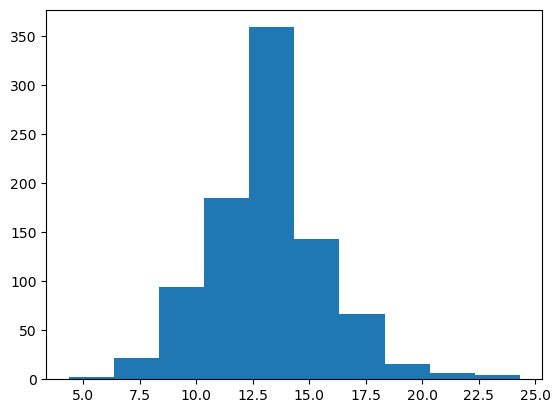

count    898.000000
mean      13.229808
std        2.582508
min        4.357762
25%       11.689436
50%       13.405718
75%       14.441679
max       24.317231
Name: Adj_NBA_TOV%, dtype: float64

In [59]:
# set the default as the average calculated above
DEFAULT_TOVP = 14

# shrink TOV rate towards the default based on number games played in NBA
draft_df['NBA_TOV%'] = draft_df['NBA_TOV%'].fillna(DEFAULT_TOVP)
draft_df['Adj_NBA_TOV%'] = DEFAULT_TOVP + (draft_df['NBA_TOV%'] - DEFAULT_TOVP) * (1 - np.exp(-draft_df['NBA_G'] / 100))

# distribution of adjusted turnover rate
plt.hist(draft_df['Adj_NBA_TOV%'])
plt.show()

# summary statistics for adjusted turnover rate
draft_df['Adj_NBA_TOV%'].describe()

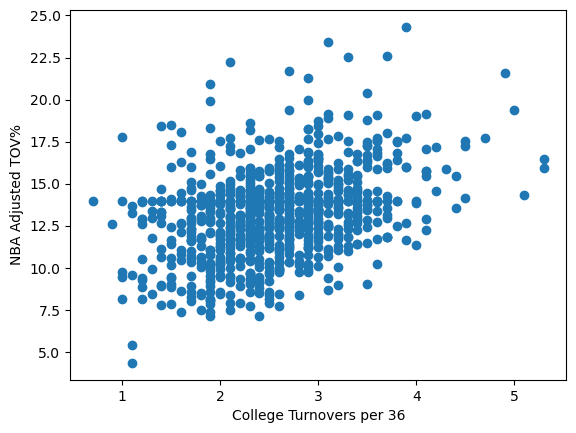

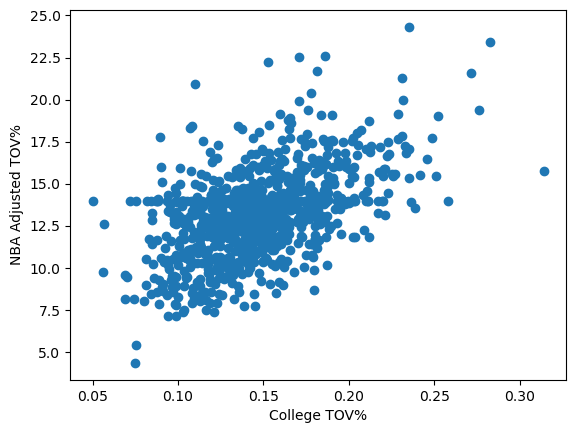

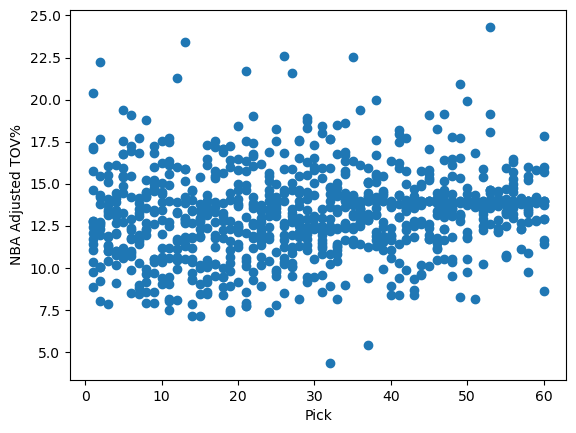

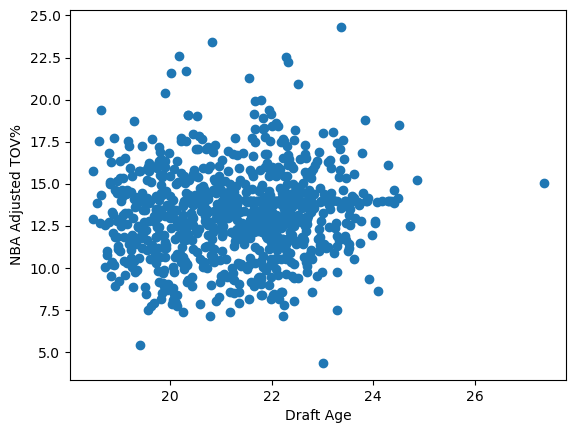

In [60]:
# Relationship of college TOV/36 to NBA turnover rate
plt.scatter(draft_df['TO'], draft_df['Adj_NBA_TOV%'])
plt.xlabel("College Turnovers per 36")
plt.ylabel("NBA Adjusted TOV%")
plt.show()

# Relationship of college turnover rate to NBA turnover rate
plt.scatter(draft_df['TOV_Rate'], draft_df['Adj_NBA_TOV%'])
plt.xlabel("College TOV%")
plt.ylabel("NBA Adjusted TOV%")
plt.show()

# Relationship of draft pick to NBA turnover rate
plt.scatter(draft_df['Pick'], draft_df['Adj_NBA_TOV%'])
plt.xlabel("Pick")
plt.ylabel("NBA Adjusted TOV%")
plt.show()

# Relationship of draft age to NBA turnover rate
plt.scatter(draft_df['Draft Age'], draft_df['Adj_NBA_TOV%'])
plt.xlabel("Draft Age")
plt.ylabel("NBA Adjusted TOV%")
plt.show()

# Modeling - Creation

In [61]:
# create response vectors
y_ast = draft_df['Adj_NBA_AST_36']
y_tov = draft_df['Adj_NBA_TOV%']

# split responses into train/test based on train/test split from before
y_ast_train = y_ast.loc[train_index]
y_ast_test = y_ast.loc[test_index]

y_tov_train = y_tov.loc[train_index]
y_tov_test = y_tov.loc[test_index]

In [62]:
# fit models for assists

models_ast = {
    'Ridge' : {'model' : Ridge(random_state = 123),
               'grid' : {'alpha' : np.arange(10,100,5)},
               'grid_search' : True},
    'LASSO' : {'model' : Lasso(random_state = 123),
               'grid' : {'alpha' : np.arange(0.001, 0.020, 0.001)},
               'grid_search' : True},
    # 'Random Forest' : {'model' : RandomForestRegressor(random_state = 123),
    #                    'grid' : {'max_depth' : np.arange(1, 10, 1),
    #                              'min_samples_split' : [5, 10, 20],
    #                              'max_features' : [0.25, 0.5, 0.75, 1]},
    #                    'grid_search' : True},
    'MLP' : {'model' : MLPRegressor(random_state = 123, shuffle = True, max_iter = 1000, n_iter_no_change = 5),
             'grid' : {'activation' : ['relu', 'logistic'],
                       'hidden_layer_sizes' : [(x,) for x in np.arange(2,10,2)],
                       'learning_rate_init' : [0.1, 0.01]},
             'grid_search' : True},
    'SVM' : {'model' : SVR(),
             'grid' : {'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
                       'C' : np.arange(0.02, 0.20, 0.02)},
             'grid_search' : True},
    # 'XGB' : {'model' : XGBRegressor(random_state = 123),
    #          'grid' : {'n_estimators' : [100, 200, 500, 1000],
    #                    'max_depth' : np.arange(3, 11, 1),
    #                    'learning_rate' : [1e-4, 1e-3, 0.01, 0.1],
    #                    'subsample' : uniform(loc = 0.1, scale = 0.9),
    #                    'colsample_bytree' : uniform(loc = 0.1, scale = 0.9),
    #                    'colsample_bylevel' : uniform(loc = 0.1, scale = 0.9),
    #                    'reg_alpha' : uniform(loc = 0, scale = 1),
    #                    'reg_lambda' : uniform(loc = 0, scale = 1)},
    #          'grid_search' : False}
}

ast_results = fitManyModels(models_ast, X_train, X_test, y_ast_train, y_ast_test, cv = cv, classifier = False)

----------RIDGE----------
Best parameters: {'alpha': 20}
Train Loss: 1.310398450932801
Validation Loss: 1.4882178646015372
----------LASSO----------


/Users/ayushbatra/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.526e+00, tolerance: 1.987e-01

/Users/ayushbatra/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.796e+00, tolerance: 2.069e-01

/Users/ayushbatra/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.307e+00, tolerance: 2.050e-01

/Users/ayushbatra/anacond

Best parameters: {'alpha': 0.010000000000000002}
Train Loss: 1.3115264429787454
Validation Loss: 1.453556523509533
----------MLP----------
Best parameters: {'activation': 'relu', 'hidden_layer_sizes': (2,), 'learning_rate_init': 0.01}
Train Loss: 1.168202127613455
Validation Loss: 1.6057159898914055
----------SVM----------
Best parameters: {'C': 0.1, 'kernel': 'linear'}
Train Loss: 1.354571202900871
Validation Loss: 1.4897937877224918


In [63]:
ast_lasso = Double_Lasso()
ast_lasso.fit_all(X_train, X_test, y_ast_train, y_ast_test, 
                  grid = models_ast['LASSO']['grid'], cv = cv, n = 0.1)

Fitting initial model...


/Users/ayushbatra/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.526e+00, tolerance: 1.987e-01

/Users/ayushbatra/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.796e+00, tolerance: 2.069e-01

/Users/ayushbatra/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.307e+00, tolerance: 2.050e-01

/Users/ayushbatra/anacond

Best parameters: {'alpha': 0.010000000000000002}
Train Loss: 1.3115264429787454
Validation Loss: 1.453556523509533

Fitting reduced model...
Best parameters: {'alpha': 0.001}
Train Loss: 1.3382331309793418
Validation Loss: 1.3939803384599638


In [64]:
# fit models for turnover rate
models_tov = {
    'Ridge' : {'model' : Ridge(random_state = 123),
               'grid' : {'alpha' : np.arange(100,200,5)},
               'grid_search' : True},
    'LASSO' : {'model' : Lasso(random_state = 123),
               'grid' : {'alpha' : np.arange(0.005, 0.10, 0.005)},
               'grid_search' : True},
    # 'Random Forest' : {'model' : RandomForestRegressor(random_state = 123),
    #                    'grid' : {'max_depth' : np.arange(1, 10, 1),
    #                              'min_samples_split' : [5, 10, 20],
    #                              'max_features' : [0.25, 0.5, 0.75, 1]},
    #                    'grid_search' : True},
    'MLP' : {'model' : MLPRegressor(random_state = 123, shuffle = True, max_iter = 1000, n_iter_no_change = 5),
             'grid' : {'activation' : ['relu', 'logistic'],
                       'hidden_layer_sizes' : [(x,) for x in np.arange(2,10,2)],
                       'learning_rate_init' : [0.1, 0.01]},
             'grid_search' : True},
    'SVM' : {'model' : SVR(),
             'grid' : {'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
                       'C' : np.arange(0.02, 0.20, 0.02)},
             'grid_search' : True},
    # 'XGB' : {'model' : XGBRegressor(random_state = 123),
    #          'grid' : {'n_estimators' : [100, 200, 500, 1000],
    #                    'max_depth' : np.arange(3, 11, 1),
    #                    'learning_rate' : [1e-4, 1e-3, 0.01, 0.1],
    #                    'subsample' : uniform(loc = 0.1, scale = 0.9),
    #                    'colsample_bytree' : uniform(loc = 0.1, scale = 0.9),
    #                    'colsample_bylevel' : uniform(loc = 0.1, scale = 0.9),
    #                    'reg_alpha' : uniform(loc = 0, scale = 1),
    #                    'reg_lambda' : uniform(loc = 0, scale = 1)},
    #          'grid_search' : False}
}

tov_results = fitManyModels(models_tov, X_train, X_test, y_tov_train, y_tov_test, cv = cv, classifier = False)

----------RIDGE----------
Best parameters: {'alpha': 150}
Train Loss: 3.9812215004689313
Validation Loss: 4.342939851451837
----------LASSO----------


/Users/ayushbatra/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.350e+00, tolerance: 4.005e-01

/Users/ayushbatra/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.169e-01, tolerance: 3.687e-01



Best parameters: {'alpha': 0.025}
Train Loss: 3.9527117767255984
Validation Loss: 4.329029080812478
----------MLP----------


/Users/ayushbatra/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.

/Users/ayushbatra/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.

/Users/ayushbatra/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.

/Users/ayushbatra/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.

/Users/ayushbatra/anaconda3/lib/python3.11/site-packages/sklearn/neural_

Best parameters: {'activation': 'relu', 'hidden_layer_sizes': (2,), 'learning_rate_init': 0.1}
Train Loss: 3.9676999078070203
Validation Loss: 5.060933939639486
----------SVM----------
Best parameters: {'C': 0.04, 'kernel': 'linear'}
Train Loss: 4.031164323843043
Validation Loss: 4.490828356212901


In [65]:
tov_lasso = Double_Lasso()
tov_lasso.fit_all(X_train, X_test, y_tov_train, y_tov_test, 
                  grid = models_tov['LASSO']['grid'], cv = cv, n = 0.1)

Fitting initial model...


/Users/ayushbatra/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.350e+00, tolerance: 4.005e-01

/Users/ayushbatra/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.169e-01, tolerance: 3.687e-01



Best parameters: {'alpha': 0.025}
Train Loss: 3.9527117767255984
Validation Loss: 4.329029080812478

Fitting reduced model...
Best parameters: {'alpha': 0.005}
Train Loss: 3.9232265956624537
Validation Loss: 4.157009556903075


In [66]:
# display coefficients for final assists model
ast_lasso.display_features()

Feature      Coef
1              AST  0.932846
3               PG  0.533834
4         log_pick  0.499054
8          AST/USG  0.360482
7           AST/TO  0.226263
10          log_MP  0.207845
12           Fouls  0.187537
5      log_AST/USG  0.171436
9              STL  0.156467
11       BLK_x_STL -0.073238
13   Wingspan_diff -0.138020
6        Draft Age -0.206999
2             Pick -0.720087
0   AST_x_log_pick -1.310895

In [67]:
# display coefficients for final turnover model
tov_lasso.display_features()

Feature      Coef
1    Height_x_AST  0.621107
5         AST/USG  0.605661
0        TOV_Rate  0.489565
3              PG  0.431559
7             REB  0.349451
15       Wingspan  0.337586
6            Pick  0.317055
10      Draft Age  0.239471
13          Fouls  0.230015
11         na_bpm  0.227357
14           FTAr  0.166497
16         DWS/40  0.133334
17  Wingspan_diff  0.026284
9             FT% -0.296559
8              PF -0.309599
12            2PM -0.356589
2              SF -0.429084
4          AST/TO -0.723118

In [68]:
# display assist predictions for players from 2004-2020
ast_lasso.full_predict(draft_df, X, y_ast).head(10)

Name  Year Draft Team                  Team Position  Pick  \
788         Ja Morant  2019        MEM          Murray State       PG     2   
682        Lonzo Ball  2017        LAL                  UCLA       PG     2   
250       Ricky Rubio  2009        MIN  DKV Joventut (Spain)       PG     5   
425  Kendall Marshall  2012        PHX        North Carolina       PG    13   
304         John Wall  2010        WAS              Kentucky       PG     1   
842       LaMelo Ball  2020        CHA       Illawarra (NBL)       PG     3   
44         Chris Paul  2005         NO           Wake Forest       PG     4   
681    Markelle Fultz  2017        PHI            Washington       PG     1   
43     Deron Williams  2005        UTA              Illinois       PG     3   
141       Mike Conley  2007        MEM            Ohio State       PG     4   

     Predicted      Real  
788   9.344296  7.638819  
682   9.204089  6.319861  
250   8.740445  8.968164  
425   8.557781  7.259816  
304   8.316878  9.126091  
842   8.279956  7.036700  
44    8.098539  9.885094  
681   7.894749  5.937853  
43    7.799664  8.502737  
141   7.797381  6.515664

In [69]:
# turnover rate predictions for 2004-2020
tov_lasso.full_predict(draft_df, X, y_tov).head(10)

Name  Year Draft Team                  Team Position  \
425         Kendall Marshall  2012        PHX        North Carolina       PG   
250              Ricky Rubio  2009        MIN  DKV Joventut (Spain)       PG   
106          Marcus Williams  2006        BKN                 UConn       PG   
111         Sergio Rodriguez  2006        POR   Estudiantes (Spain)       PG   
45            Raymond Felton  2005        CHA        North Carolina       PG   
11           Pavel Podkolzin  2004        DAL  Metis Varese (Italy)        C   
478  Michael Carter-Williams  2013        PHI              Syracuse       PG   
26               Chris Duhon  2004        CHI                  Duke       PG   
516            Lorenzo Brown  2013        MIN              NC State       PG   
332             Daniel Orton  2010        ORL              Kentucky        C   

     Pick  Predicted       Real  
425    13  19.395730  23.395669  
250     5  19.140624  19.370369  
106    22  18.522642  19.034128  
111    27  18.456966  21.600114  
45      5  17.850263  15.477208  
11     21  17.608654  15.754967  
478    11  17.579542  17.493710  
26     38  17.473378  19.950356  
516    52  17.389418  15.891756  
332    29  17.354960  15.494825

In [70]:
# assist predictions for 2021-2023
ast_lasso.full_predict(recent_df, X_r).head(10)

Name  Year Draft Team                  Team Position  Pick  \
4        Josh Giddey  2021        OKC  Adelaide (Australia)       PG     6   
117  Scoot Henderson  2023        POR              G League       PG     3   
118    Amen Thompson  2023        HOU        Overtime Elite    SG/PG     4   
7    Davion Mitchell  2021        SAC                Baylor       PG     9   
124    Cason Wallace  2023        OKC              Kentucky       PG    10   
119   Ausar Thompson  2023        DET        Overtime Elite    SG/SF     5   
3        Jalen Suggs  2021        ORL               Gonzaga    PG/SG     5   
0    Cade Cunningham  2021        DET        Oklahoma State       PG     1   
2     Scottie Barnes  2021        TOR         Florida State       PF     4   
75       Dalen Terry  2022        CHI               Arizona    SG/PG    18   

     Predicted  
4     7.962309  
117   7.567496  
118   7.532134  
7     6.055905  
124   5.986801  
119   5.675355  
3     5.408292  
0     5.391724  
2     5.176002  
75    5.113295

In [71]:
# turnover predictions for 2021-2023
tov_lasso.full_predict(recent_df, X_r).head(10)

Name  Year Draft Team                  Team Position  Pick  \
110         JD Davison  2022        BOS               Alabama       PG    53   
4          Josh Giddey  2021        OKC  Adelaide (Australia)       PG     6   
44       Dalano Banton  2021        TOR              Nebraska       PG    46   
118      Amen Thompson  2023        HOU        Overtime Elite    SG/PG     4   
31       Jason Preston  2021        LAC                  Ohio       PG    33   
150  Andre Jackson Jr.  2023        MIL                 UConn    SG/SF    36   
56        Jericho Sims  2021         NY                 Texas        C    58   
145        James Nnaji  2023        CHA     Barcelona (Spain)        C    31   
96        Khalifa Diop  2022        CLE  Gran Canaria (Spain)        C    39   
46      Sharife Cooper  2021        ATL                Auburn       PG    48   

     Predicted  
110  17.911553  
4    17.804307  
44   17.345917  
118  17.066429  
31   16.465178  
150  16.390962  
56   16.241833  
145  16.209508  
96   16.138003  
46   16.132638

In [72]:
# assist predictions for 2024 prospects
ast_lasso.full_predict(draft24, X_24).head(10)

Name  Year  Draft Team                      Team Position  \
0         Nikola Topić  2024         NaN         Red Star (Serbia)       PG   
1        Reed Sheppard  2024         NaN                  Kentucky    PG/SG   
8       Rob Dillingham  2024         NaN                  Kentucky       PG   
5       Stephon Castle  2024         NaN                     UConn    PG/SG   
29  Carlton Carrington  2024         NaN                Pittsburgh       PG   
19      Isaiah Collier  2024         NaN                       USC       PG   
23         Tyler Kolek  2024         NaN                 Marquette       PG   
12        Devin Carter  2024         NaN                Providence       PG   
46         Jamal Shead  2024         NaN                   Houston       PG   
34          Juan Núñez  2024         NaN  Ratiopharm Ulm (Germany)       PG   

    Pick  Predicted  
0    8.4   7.154437  
1    3.4   6.778691  
8    8.8   5.904874  
5    4.6   4.880678  
29  20.2   4.850610  
19  19.2   4.807328  
23  24.2   4.753050  
12  10.6   4.396426  
46  46.4   3.756452  
34  41.6   3.750847

In [73]:
# turnover rate predictions for 2024 prospects
tov_lasso.full_predict(draft24, X_24).head(10)

Name  Year  Draft Team                      Team Position  \
34       Juan Núñez  2024         NaN  Ratiopharm Ulm (Germany)       PG   
62   Ariel Hukporti  2024         NaN           Melbourne (NBL)        C   
43        Adem Bona  2024         NaN                      UCLA        C   
55   Tristen Newton  2024         NaN                     UConn    PG/SG   
23      Tyler Kolek  2024         NaN                 Marquette       PG   
58  Trentyn Flowers  2024         NaN            Adelaide (NBL)       SG   
64     N'Faly Dante  2024         NaN                    Oregon        C   
66     Bronny James  2024         NaN                       USC    PG/SG   
60     Quinten Post  2024         NaN            Boston College        C   
19   Isaiah Collier  2024         NaN                       USC       PG   

    Pick  Predicted  
34  41.6  17.392591  
62  63.8  16.858744  
43  38.6  15.198705  
55  56.2  15.191824  
23  24.2  15.157817  
58  52.6  15.000464  
64  65.2  14.959138  
66  57.6  14.897270  
60  63.0  14.689864  
19  19.2  14.651113

In [74]:
print(f"Assists Model Test Set Score: {ast_lasso.score(X_test, y_ast_test)}")
print(f"TOV% Model Test Set Score: {tov_lasso.score(X_test, y_tov_test)}")

Assists Model Test Set Score: 0.5767879844332335
TOV% Model Test Set Score: 0.37306207885707177


# EDA - Shooting

## 3-Pointers Made

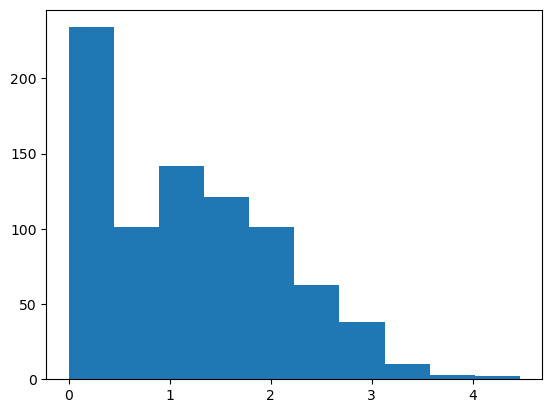

In [75]:
plt.hist(draft_df["NBA_3PM_36"])
plt.show()

In [76]:
draft_df['NBA_3PM_36'].describe()

count    815.000000
mean       1.169950
std        0.927719
min        0.000000
25%        0.251950
50%        1.141791
75%        1.848210
max        4.465116
Name: NBA_3PM_36, dtype: float64

In [77]:
draft_df['NBA_3PM_36'].isnull().mean()

0.09242761692650334

In [78]:
draft_df['NBA_3PM_36'] = draft_df['NBA_3PM_36'].fillna(0)

draft_df['Adj_NBA_3PM_36'] = draft_df['NBA_3PM_36'] * (1 - np.exp(-draft_df['NBA_G'] / 100))

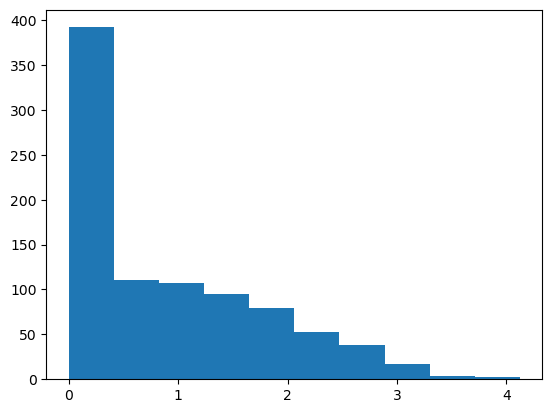

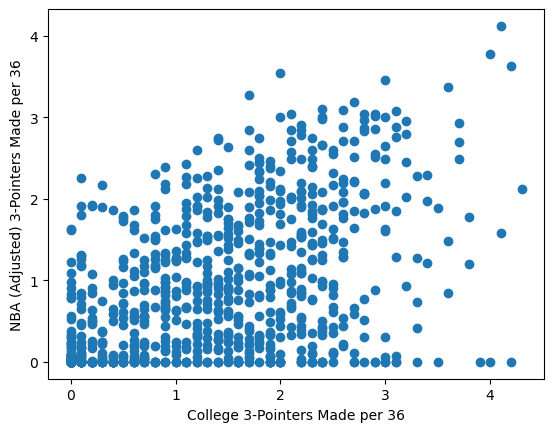

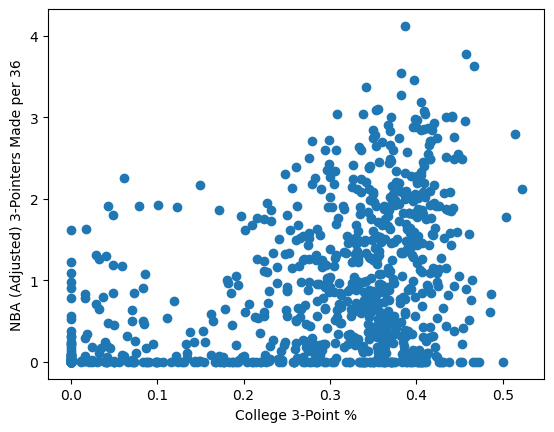

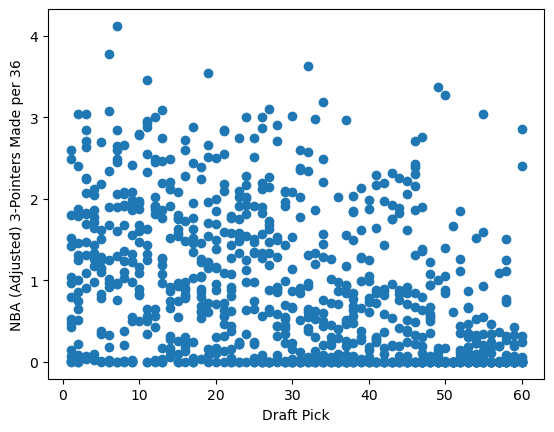

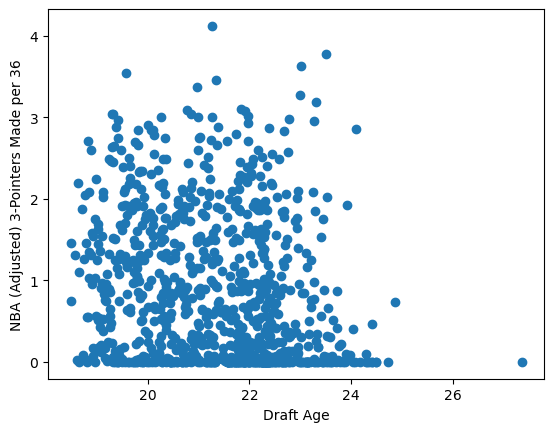

count    898.000000
mean       0.870261
std        0.897599
min        0.000000
25%        0.026647
50%        0.614399
75%        1.508366
max        4.121948
Name: Adj_NBA_3PM_36, dtype: float64

In [79]:
plt.hist(draft_df['Adj_NBA_3PM_36'])
plt.show()


plt.scatter(draft_df['3PM'], draft_df['Adj_NBA_3PM_36'])
plt.xlabel("College 3-Pointers Made per 36")
plt.ylabel("NBA (Adjusted) 3-Pointers Made per 36")
plt.show()

plt.scatter(draft_df['3P%'], draft_df['Adj_NBA_3PM_36'])
plt.xlabel("College 3-Point %")
plt.ylabel("NBA (Adjusted) 3-Pointers Made per 36")
plt.show()


plt.scatter(draft_df['Pick'], draft_df['Adj_NBA_3PM_36'])
plt.xlabel("Draft Pick")
plt.ylabel("NBA (Adjusted) 3-Pointers Made per 36")
plt.show()

plt.scatter(draft_df['Draft Age'], draft_df['Adj_NBA_3PM_36'])
plt.xlabel("Draft Age")
plt.ylabel("NBA (Adjusted) 3-Pointers Made per 36")
plt.show()

draft_df['Adj_NBA_3PM_36'].describe()

## 3-Point Percentage

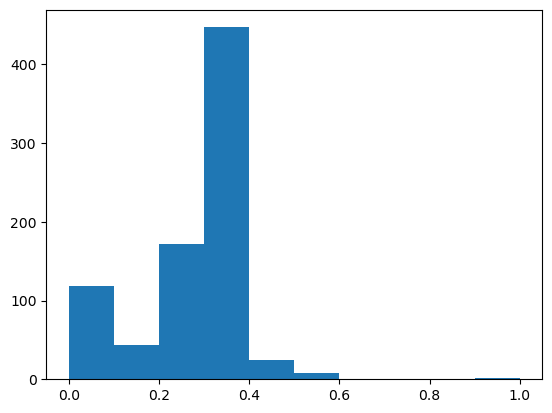

In [80]:
plt.hist(draft_df['NBA_3P%'])
plt.show()

In [81]:
draft_df['NBA_3P%'].describe()

count    815.000000
mean       0.274885
std        0.129925
min        0.000000
25%        0.235448
50%        0.322118
75%        0.358403
max        1.000000
Name: NBA_3P%, dtype: float64

In [82]:
draft_df[draft_df['NBA_G'] <= 100]['NBA_3P%'].mean()

0.1968294087694669

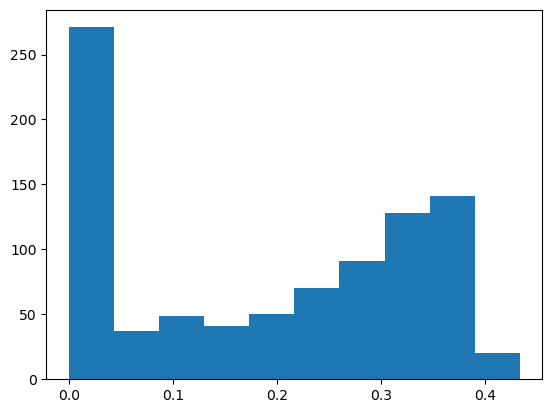

count    898.000000
mean       0.188918
std        0.145953
min        0.000000
25%        0.013307
50%        0.217323
75%        0.331333
max        0.433426
Name: Adj_NBA_3P%, dtype: float64

In [83]:
DEFAULT_3PP = 0.2

draft_df['NBA_3P%'] = draft_df['NBA_3P%'].fillna(DEFAULT_3PP)
draft_df['Adj_NBA_3P%'] = DEFAULT_3PP + (draft_df['NBA_3P%'] - DEFAULT_3PP) * (1 - np.exp(-draft_df['NBA_G'] / 100))
draft_df['Adj_NBA_3P%'] = draft_df['Adj_NBA_3P%'] * (2 / (1 + np.exp(-draft_df['Adj_NBA_3PM_36'] / draft_df['Adj_NBA_3P%'])) - 1)
draft_df['Adj_NBA_3P%'] = draft_df['Adj_NBA_3P%'].fillna(0)

plt.hist(draft_df['Adj_NBA_3P%'])
plt.show()

draft_df['Adj_NBA_3P%'].describe()

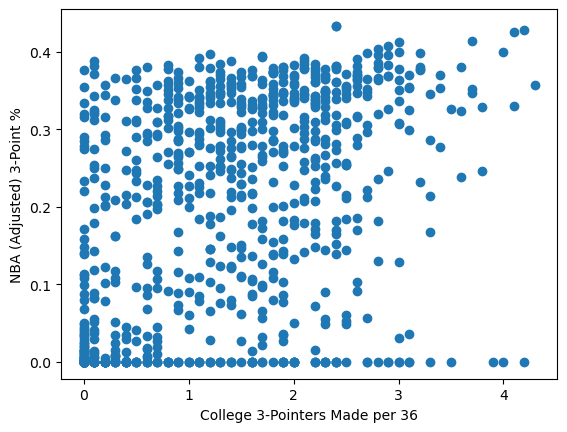

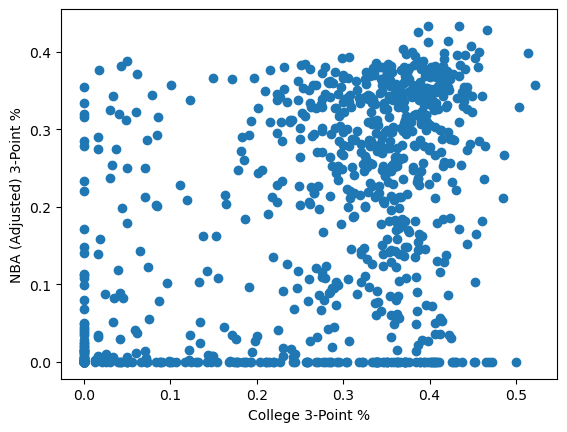

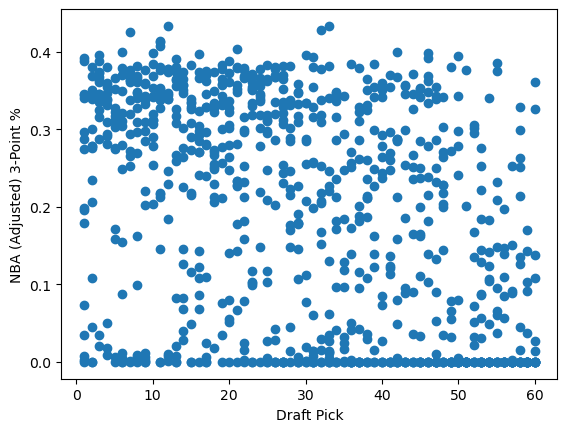

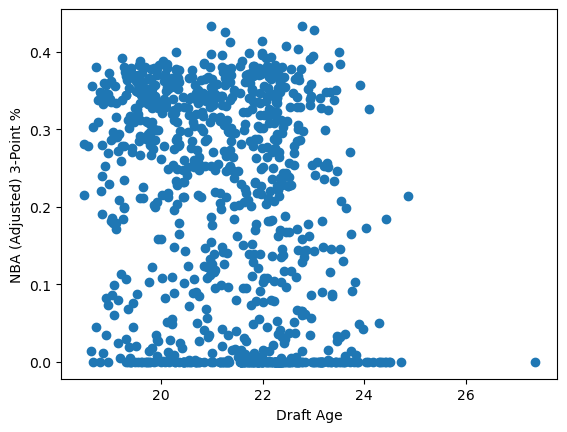

In [84]:
plt.scatter(draft_df['3PM'], draft_df['Adj_NBA_3P%'])
plt.xlabel("College 3-Pointers Made per 36")
plt.ylabel("NBA (Adjusted) 3-Point %")
plt.show()

plt.scatter(draft_df['3P%'], draft_df['Adj_NBA_3P%'])
plt.xlabel("College 3-Point %")
plt.ylabel("NBA (Adjusted) 3-Point %")
plt.show()


plt.scatter(draft_df['Pick'], draft_df['Adj_NBA_3P%'])
plt.xlabel("Draft Pick")
plt.ylabel("NBA (Adjusted) 3-Point %")
plt.show()

plt.scatter(draft_df['Draft Age'], draft_df['Adj_NBA_3P%'])
plt.xlabel("Draft Age")
plt.ylabel("NBA (Adjusted) 3-Point %")
plt.show()

# Modeling - Shooting

In [85]:
# define a transformation for the 3-pointers made vector
# model the log of the 3's made instead of the actual 3's made
def transform(y):
    return np.log(y + 1)

def inv_transform(y):
    ynew = np.exp(y) - 1
    ynew = np.where(ynew < 0, 0, ynew)
    return ynew

(array([392., 111., 107.,  95.,  79.,  53.,  38.,  17.,   4.,   2.]),
 array([0.        , 0.41219476, 0.82438952, 1.23658428, 1.64877904,
        2.0609738 , 2.47316856, 2.88536332, 3.29755807, 3.70975283,
        4.12194759]),
 <BarContainer object of 10 artists>)

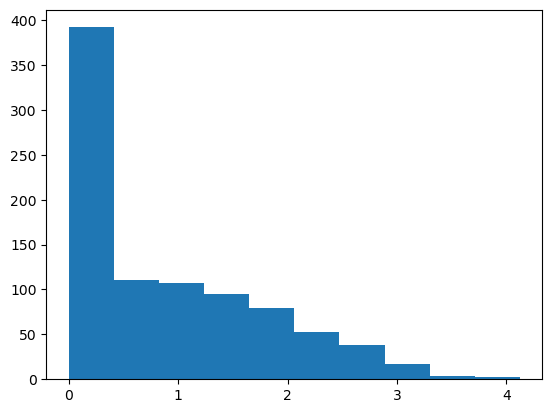

In [86]:
# create response vector
y_tpm = draft_df['Adj_NBA_3PM_36']
# plot distribution
plt.hist(y_tpm)

(array([271.,  37.,  49.,  41.,  50.,  70.,  91., 128., 141.,  20.]),
 array([0.        , 0.04334262, 0.08668523, 0.13002785, 0.17337047,
        0.21671308, 0.2600557 , 0.30339832, 0.34674093, 0.39008355,
        0.43342617]),
 <BarContainer object of 10 artists>)

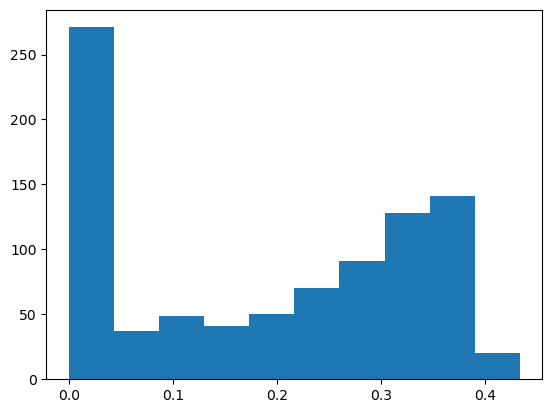

In [87]:
# response vector
y_tpp = draft_df['Adj_NBA_3P%']

# visualize new distribution of 3P%
plt.hist(y_tpp)

In [88]:
y_tpm_train = y_tpm.loc[train_index]
y_tpm_test = y_tpm.loc[test_index]

y_tpp_train = y_tpp.loc[train_index]
y_tpp_test = y_tpp.loc[test_index]

In [89]:
models_tpm = {
    'Ridge' : {'model' : Ridge(random_state = 123),
               'grid' : {'alpha' : np.arange(10,100,5)},
               'grid_search' : True},
    'LASSO' : {'model' : Lasso(random_state = 123),
               'grid' : {'alpha' : np.arange(0.005, 0.020, 0.001)},
               'grid_search' : True},
    # 'Random Forest' : {'model' : RandomForestRegressor(random_state = 123),
    #                    'grid' : {'max_depth' : np.arange(1, 10, 1),
    #                              'min_samples_split' : [5, 10, 20],
    #                              'max_features' : [0.25, 0.5, 0.75, 1]},
    #                    'grid_search' : True},
    'MLP' : {'model' : MLPRegressor(random_state = 123, shuffle = True, max_iter = 1000, n_iter_no_change = 5),
             'grid' : {'activation' : ['relu', 'logistic'],
                       'hidden_layer_sizes' : [(x,) for x in np.arange(2,10,2)],
                       'learning_rate_init' : [0.1, 0.01]},
             'grid_search' : True},
    'SVM' : {'model' : SVR(),
             'grid' : {'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
                       'C' : np.arange(0.02, 0.20, 0.02)},
             'grid_search' : True},
    # 'XGB' : {'model' : XGBRegressor(random_state = 123),
    #          'grid' : {'n_estimators' : [100, 200, 500, 1000],
    #                    'max_depth' : np.arange(3, 11, 1),
    #                    'learning_rate' : [1e-4, 1e-3, 0.01, 0.1],
    #                    'subsample' : uniform(loc = 0.1, scale = 0.9),
    #                    'colsample_bytree' : uniform(loc = 0.1, scale = 0.9),
    #                    'colsample_bylevel' : uniform(loc = 0.1, scale = 0.9),
    #                    'reg_alpha' : uniform(loc = 0, scale = 1),
    #                    'reg_lambda' : uniform(loc = 0, scale = 1)},
    #          'grid_search' : False}
}

tpm_results = fitManyModels(models_tpm, X_train, X_test, y_tpm_train, y_tpm_test, cv = cv, classifier = False)

----------RIDGE----------
Best parameters: {'alpha': 90}
Train Loss: 0.39437364206512193
Validation Loss: 0.43681699065208673
----------LASSO----------
Best parameters: {'alpha': 0.01}
Train Loss: 0.39489800200548864
Validation Loss: 0.4338863177071623
----------MLP----------
Best parameters: {'activation': 'logistic', 'hidden_layer_sizes': (2,), 'learning_rate_init': 0.01}
Train Loss: 0.3307125879840515
Validation Loss: 0.47122959654277974
----------SVM----------
Best parameters: {'C': 0.02, 'kernel': 'linear'}
Train Loss: 0.4042917027617121
Validation Loss: 0.4562583882935166


In [90]:
tpm_lasso = Double_Lasso()
tpm_lasso.fit_all(X_train, X_test, y_tpm_train, y_tpm_test, 
                  grid = models_tpm['LASSO']['grid'], cv = cv, n = 0.1)

Fitting initial model...
Best parameters: {'alpha': 0.01}
Train Loss: 0.39489800200548864
Validation Loss: 0.4338863177071623

Fitting reduced model...
Best parameters: {'alpha': 0.005}
Train Loss: 0.39575252958122
Validation Loss: 0.42240102221508824


In [91]:
models_tpm2 = {
    'Ridge' : {'model' : Ridge(random_state = 123),
               'grid' : {'alpha' : np.arange(10,100,5)},
               'grid_search' : True},
    'LASSO' : {'model' : Lasso(random_state = 123),
               'grid' : {'alpha' : np.arange(0.001, 0.020, 0.001)},
               'grid_search' : True},
    # 'Random Forest' : {'model' : RandomForestRegressor(random_state = 123),
    #                    'grid' : {'max_depth' : np.arange(1, 10, 1),
    #                              'min_samples_split' : [5, 10, 20],
    #                              'max_features' : [0.25, 0.5, 0.75, 1]},
    #                    'grid_search' : True},
    'MLP' : {'model' : MLPRegressor(random_state = 123, shuffle = True, max_iter = 1000, n_iter_no_change = 5),
             'grid' : {'activation' : ['relu', 'logistic'],
                       'hidden_layer_sizes' : [(x,) for x in np.arange(2,10,2)],
                       'learning_rate_init' : [0.1, 0.01]},
             'grid_search' : True},
    'SVM' : {'model' : SVR(),
             'grid' : {'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
                       'C' : np.arange(0.02, 0.20, 0.02)},
             'grid_search' : True},
    # 'XGB' : {'model' : XGBRegressor(random_state = 123),
    #          'grid' : {'n_estimators' : [100, 200, 500, 1000],
    #                    'max_depth' : np.arange(3, 11, 1),
    #                    'learning_rate' : [1e-4, 1e-3, 0.01, 0.1],
    #                    'subsample' : uniform(loc = 0.1, scale = 0.9),
    #                    'colsample_bytree' : uniform(loc = 0.1, scale = 0.9),
    #                    'colsample_bylevel' : uniform(loc = 0.1, scale = 0.9),
    #                    'reg_alpha' : uniform(loc = 0, scale = 1),
    #                    'reg_lambda' : uniform(loc = 0, scale = 1)},
    #          'grid_search' : False}
}

tpm_results2 = fitManyModels(models_tpm2, X_train, X_test, transform(y_tpm_train), transform(y_tpm_test), cv = cv, classifier = False)

----------RIDGE----------
Best parameters: {'alpha': 85}
Train Loss: 0.096678595977007
Validation Loss: 0.10695671773265485
----------LASSO----------
Best parameters: {'alpha': 0.004}
Train Loss: 0.09651491497488499
Validation Loss: 0.10713148510243982
----------MLP----------
Best parameters: {'activation': 'logistic', 'hidden_layer_sizes': (2,), 'learning_rate_init': 0.01}
Train Loss: 0.08933035836079668
Validation Loss: 0.10917249614835227
----------SVM----------
Best parameters: {'C': 0.18, 'kernel': 'rbf'}
Train Loss: 0.07770474142778831
Validation Loss: 0.10996173416948682


In [92]:
tpm_lasso2 = Double_Lasso()
tpm_lasso2.fit_all(X_train, X_test, transform(y_tpm_train), transform(y_tpm_test),
                   grid = models_tpm2['LASSO']['grid'], cv = cv, n = 0.1)

Fitting initial model...
Best parameters: {'alpha': 0.004}
Train Loss: 0.09651491497488499
Validation Loss: 0.10713148510243982

Fitting reduced model...
Best parameters: {'alpha': 0.001}
Train Loss: 0.09708910685526355
Validation Loss: 0.10382364635778327


In [93]:
models_tpp = {
    'Ridge' : {'model' : Ridge(random_state = 123),
               'grid' : {'alpha' : np.arange(10,200,10)},
               'grid_search' : True},
    'LASSO' : {'model' : Lasso(random_state = 123),
               'grid' : {'alpha' : np.arange(0.0005, 0.0020, 0.0001)},
               'grid_search' : True},
    # 'Random Forest' : {'model' : RandomForestRegressor(random_state = 123),
    #                    'grid' : {'max_depth' : np.arange(1, 10, 1),
    #                              'min_samples_split' : [5, 10, 20],
    #                              'max_features' : [0.25, 0.5, 0.75, 1]},
    #                    'grid_search' : True},
    'MLP' : {'model' : MLPRegressor(random_state = 123, shuffle = True, max_iter = 1000, n_iter_no_change = 5),
             'grid' : {'activation' : ['relu', 'logistic'],
                       'hidden_layer_sizes' : [(x,) for x in np.arange(2,10,2)],
                       'learning_rate_init' : [0.1, 0.01]},
             'grid_search' : True},
    'SVM' : {'model' : SVR(),
             'grid' : {'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
                       'C' : np.arange(0.02, 0.20, 0.02)},
             'grid_search' : True},
    # 'XGB' : {'model' : XGBRegressor(random_state = 123),
    #          'grid' : {'n_estimators' : [100, 200, 500, 1000],
    #                    'max_depth' : np.arange(3, 11, 1),
    #                    'learning_rate' : [1e-4, 1e-3, 0.01, 0.1],
    #                    'subsample' : uniform(loc = 0.1, scale = 0.9),
    #                    'colsample_bytree' : uniform(loc = 0.1, scale = 0.9),
    #                    'colsample_bylevel' : uniform(loc = 0.1, scale = 0.9),
    #                    'reg_alpha' : uniform(loc = 0, scale = 1),
    #                    'reg_lambda' : uniform(loc = 0, scale = 1)},
    #          'grid_search' : False}
}

tpp_results = fitManyModels(models_tpp, X_train, X_test, y_tpp_train, y_tpp_test, cv = cv, classifier = False)

----------RIDGE----------
Best parameters: {'alpha': 60}
Train Loss: 0.009951307836293445
Validation Loss: 0.011049761615252434
----------LASSO----------
Best parameters: {'alpha': 0.0011000000000000003}
Train Loss: 0.009995062635214184
Validation Loss: 0.01109497137424084
----------MLP----------
Best parameters: {'activation': 'logistic', 'hidden_layer_sizes': (4,), 'learning_rate_init': 0.01}
Train Loss: 0.0097953883782047
Validation Loss: 0.011223002032087457
----------SVM----------
Best parameters: {'C': 0.02, 'kernel': 'linear'}
Train Loss: 0.009948772272808958
Validation Loss: 0.01172293963572102


In [94]:
tpp_lasso = Double_Lasso()
tpp_lasso.fit_all(X_train, X_test, y_tpp_train, y_tpp_test, 
                  grid = models_tpp['LASSO']['grid'], cv = cv, n = 0.1)

Fitting initial model...
Best parameters: {'alpha': 0.0011000000000000003}
Train Loss: 0.009995062635214184
Validation Loss: 0.01109497137424084

Fitting reduced model...
Best parameters: {'alpha': 0.0005}
Train Loss: 0.010089349524371558
Validation Loss: 0.010675284728422335


In [95]:
models_tpp2 = {
    'Ridge' : {'model' : Ridge(random_state = 123),
               'grid' : {'alpha' : np.arange(10,100,5)},
               'grid_search' : True},
    'LASSO' : {'model' : Lasso(random_state = 123),
               'grid' : {'alpha' : np.arange(0.0005, 0.0020, 0.0001)},
               'grid_search' : True},
    # 'Random Forest' : {'model' : RandomForestRegressor(random_state = 123),
    #                    'grid' : {'max_depth' : np.arange(1, 10, 1),
    #                              'min_samples_split' : [5, 10, 20],
    #                              'max_features' : [0.25, 0.5, 0.75, 1]},
    #                    'grid_search' : True},
    'MLP' : {'model' : MLPRegressor(random_state = 123, shuffle = True, max_iter = 1000, n_iter_no_change = 5),
             'grid' : {'activation' : ['relu', 'logistic'],
                       'hidden_layer_sizes' : [(x,) for x in np.arange(2,10,2)],
                       'learning_rate_init' : [0.1, 0.01]},
             'grid_search' : True},
    'SVM' : {'model' : SVR(),
             'grid' : {'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
                       'C' : np.arange(0.02, 0.20, 0.02)},
             'grid_search' : True},
    # 'XGB' : {'model' : XGBRegressor(random_state = 123),
    #          'grid' : {'n_estimators' : [100, 200, 500, 1000],
    #                    'max_depth' : np.arange(3, 11, 1),
    #                    'learning_rate' : [1e-4, 1e-3, 0.01, 0.1],
    #                    'subsample' : uniform(loc = 0.1, scale = 0.9),
    #                    'colsample_bytree' : uniform(loc = 0.1, scale = 0.9),
    #                    'colsample_bylevel' : uniform(loc = 0.1, scale = 0.9),
    #                    'reg_alpha' : uniform(loc = 0, scale = 1),
    #                    'reg_lambda' : uniform(loc = 0, scale = 1)},
    #          'grid_search' : False}
}

tpp_results2 = fitManyModels(models_tpp2, X_train, X_test, transform(y_tpp_train), transform(y_tpp_test), cv = cv, classifier = False)

----------RIDGE----------
Best parameters: {'alpha': 60}
Train Loss: 0.007225608277000891
Validation Loss: 0.008015848984124965
----------LASSO----------
Best parameters: {'alpha': 0.0010000000000000002}
Train Loss: 0.007268500112766712
Validation Loss: 0.00802686566513816
----------MLP----------
Best parameters: {'activation': 'logistic', 'hidden_layer_sizes': (4,), 'learning_rate_init': 0.01}
Train Loss: 0.007095314906327251
Validation Loss: 0.00819812357912185
----------SVM----------
Best parameters: {'C': 0.02, 'kernel': 'linear'}
Train Loss: 0.00741900643751681
Validation Loss: 0.00863273634266025


In [96]:
tpp_lasso2 = Double_Lasso()
tpp_lasso2.fit_all(X_train, X_test, transform(y_tpp_train), transform(y_tpp_test),
                   grid = models_tpp2['LASSO']['grid'], cv = cv, n = 0.1)

Fitting initial model...
Best parameters: {'alpha': 0.0010000000000000002}
Train Loss: 0.007268500112766712
Validation Loss: 0.00802686566513816

Fitting reduced model...
Best parameters: {'alpha': 0.0005}
Train Loss: 0.0073085632753707025
Validation Loss: 0.007740152971187622


In [97]:
print(tpm_lasso.get_loss())
print(mean_squared_error(y_tpm_train, inv_transform(tpm_lasso2.predict(X_train))))
print(mean_squared_error(y_tpm_test, inv_transform(tpm_lasso2.predict(X_test))))

{'Train': 0.39575252958122, 'Validation': 0.42240102221508824, 'Test': 0.4717909886642521}
0.3873479229754075
0.4785462670051389


In [98]:
print(tpp_lasso.get_loss())
print(mean_squared_error(y_tpp_train, inv_transform(tpp_lasso2.predict(X_train))))
print(mean_squared_error(y_tpp_test, inv_transform(tpp_lasso2.predict(X_test))))

{'Train': 0.010089349524371558, 'Validation': 0.010675284728422335, 'Test': 0.00974358519980897}
0.009869780644211913
0.009737614732239018


In [99]:
tpm_lasso.display_features()

Feature      Coef
1              3PA  0.242031
4              FT%  0.105988
2              3PM  0.094058
6              BPM  0.087767
7            Fouls  0.069015
9               SF  0.060926
14            DBPM  0.054959
12       Draft Age -0.052113
11             FTA -0.061156
15  AST_x_log_pick -0.065203
8         inv_pick -0.082841
10       BLK_x_STL -0.086330
5    Wingspan_diff -0.090107
13          Height -0.100569
3           na_bpm -0.131642
0             Pick -0.314522

In [100]:
tpp_lasso.display_features()

Feature      Coef
1             3P%  0.035128
2             FT%  0.019631
5           Fouls  0.014540
13            BPM  0.013768
9              SF  0.009638
16            2P%  0.009631
14         log_MP  0.008818
12         Height -0.010408
15           eFG% -0.011206
10       inv_pick -0.012713
8            FTAr -0.014142
11             PF -0.014625
4       Draft Age -0.015441
7               C -0.016750
6   Wingspan_diff -0.017113
3          na_bpm -0.018570
0            Pick -0.057734

In [101]:
tpm_lasso.full_predict(draft_df, X, y_tpm).head(10)

Name  Year Draft Team            Team Position  Pick  \
252             Stephen Curry  2009         GS        Davidson       PG     7   
737                Trae Young  2018        ATL        Oklahoma       PG     5   
635               Buddy Hield  2016         NO        Oklahoma       SG     6   
853             Aaron Nesmith  2020        BOS      Vanderbilt       SF    14   
792                Coby White  2019        CHI  North Carolina    PG/SG     7   
642          Denzel Valentine  2016        CHI  Michigan State    SF/SG    14   
796           Cameron Johnson  2019        PHX  North Carolina       SF    11   
475  Kentavious Caldwell-Pope  2013        DET         Georgia       SG     8   
368           Jimmer Fredette  2011        SAC             BYU    PG/SG    10   
636              Jamal Murray  2016        DEN        Kentucky    SG/PG     7   

     Predicted      Real  
252   2.549229  4.121948  
737   2.514150  2.699196  
635   2.368861  3.774599  
853   2.351442  2.117689  
792   2.336991  2.652346  
642   2.244519  2.489381  
796   2.239621  2.955899  
475   2.217155  2.064382  
368   2.202422  1.968243  
636   2.194318  2.456015

In [102]:
tpp_lasso.full_predict(draft_df, X, y_tpp).head(10)

Name  Year Draft Team              Team Position  Pick  \
798     Tyler Herro  2019        MIA          Kentucky       SG    13   
737      Trae Young  2018        ATL          Oklahoma       PG     5   
683    Jayson Tatum  2017        BOS              Duke       SF     3   
252   Stephen Curry  2009         GS          Davidson       PG     7   
792      Coby White  2019        CHI    North Carolina    PG/SG     7   
691    Luke Kennard  2017        DET              Duke       SG    12   
533  Doug McDermott  2014        CHI         Creighton       SF    11   
853   Aaron Nesmith  2020        BOS        Vanderbilt       SF    14   
474    Ben McLemore  2013        SAC            Kansas       SG     7   
369   Klay Thompson  2011         GS  Washington State    SG/SF    11   

     Predicted      Real  
798   0.414958  0.373690  
737   0.394655  0.351685  
683   0.391171  0.373644  
252   0.387809  0.425485  
792   0.383527  0.363469  
691   0.382844  0.433193  
533   0.382755  0.408041  
853   0.380340  0.356978  
474   0.379310  0.361487  
369   0.373865  0.412544

In [103]:
tpm_lasso.full_predict(recent_df, X_r).head(10)

Name  Year Draft Team      Team Position  Pick  Predicted
128   Jordan Hawkins  2023         NO     UConn       SG    14   2.407945
116   Brandon Miller  2023        CHA   Alabama       SF     2   2.385305
13     Corey Kispert  2021        WAS   Gonzaga       SF    15   2.345272
127      Gradey Dick  2023        TOR    Kansas    SG/SF    13   2.137991
23    Quentin Grimes  2021         NY   Houston       SG    25   2.128836
73        AJ Griffin  2022        ATL      Duke       SF    16   2.009977
15   Trey Murphy III  2021         NO  Virginia    SF/SG    17   1.975356
125      Jett Howard  2023        ORL  Michigan       SG    11   1.974061
130   Keyonte George  2023        UTA    Baylor       SG    16   1.969105
139    Marcus Sasser  2023        DET   Houston    PG/SG    25   1.966213

In [104]:
tpp_lasso.full_predict(recent_df, X_r).head(10)

Name  Year Draft Team         Team Position  Pick  \
13        Corey Kispert  2021        WAS      Gonzaga       SF    15   
6          Franz Wagner  2021        ORL     Michigan       SF     8   
127         Gradey Dick  2023        TOR       Kansas    SG/SF    13   
116      Brandon Miller  2023        CHA      Alabama       SF     2   
15      Trey Murphy III  2021         NO     Virginia    SF/SG    17   
16             Tre Mann  2021        OKC      Florida       PG    18   
73           AJ Griffin  2022        ATL         Duke       SF    16   
129         Kobe Bufkin  2023        ATL     Michigan    SG/PG    15   
128      Jordan Hawkins  2023         NO        UConn       SG    14   
133  Brandin Podziemski  2023         GS  Santa Clara       SG    19   

     Predicted  
13    0.394283  
6     0.390730  
127   0.383101  
116   0.377407  
15    0.364800  
16    0.360333  
73    0.359144  
129   0.357351  
128   0.351228  
133   0.349931

In [105]:
tpm_lasso.full_predict(draft24, X_24).head(10)

Name  Year  Draft Team               Team Position  Pick  \
13        Jared McCain  2024         NaN               Duke    PG/SG  14.4   
1        Reed Sheppard  2024         NaN           Kentucky    PG/SG   3.4   
8       Rob Dillingham  2024         NaN           Kentucky       PG   8.8   
7        Dalton Knecht  2024         NaN          Tennessee       SF   7.4   
28   Baylor Scheierman  2024         NaN          Creighton       SF  28.8   
12        Devin Carter  2024         NaN         Providence       PG  10.6   
0         Nikola Topić  2024         NaN  Red Star (Serbia)       PG   8.4   
2   Zaccharie Risacher  2024         NaN  JL Bourg (France)       SF   3.2   
17       Johnny Furphy  2024         NaN             Kansas       SG  22.6   
14      Ja'Kobe Walter  2024         NaN             Baylor       SG  15.4   

    Predicted  
13   2.252067  
1    2.219486  
8    2.208476  
7    2.164084  
28   2.003227  
12   1.851760  
0    1.832800  
2    1.746426  
17   1.718312  
14   1.711587

In [106]:
tpp_lasso.full_predict(draft24, X_24).head(10)

Name  Year  Draft Team               Team Position  Pick  \
1        Reed Sheppard  2024         NaN           Kentucky    PG/SG   3.4   
8       Rob Dillingham  2024         NaN           Kentucky       PG   8.8   
0         Nikola Topić  2024         NaN  Red Star (Serbia)       PG   8.4   
13        Jared McCain  2024         NaN               Duke    PG/SG  14.4   
7        Dalton Knecht  2024         NaN          Tennessee       SF   7.4   
2   Zaccharie Risacher  2024         NaN  JL Bourg (France)       SF   3.2   
5       Stephon Castle  2024         NaN              UConn    PG/SG   4.6   
17       Johnny Furphy  2024         NaN             Kansas       SG  22.6   
29  Carlton Carrington  2024         NaN         Pittsburgh       PG  20.2   
4        Matas Buzelis  2024         NaN           G League       SF   5.6   

    Predicted  
1    0.418973  
8    0.399953  
0    0.385519  
13   0.378909  
7    0.347303  
2    0.337474  
5    0.325279  
17   0.321407  
29   0.317236  
4    0.317040

In [107]:
print(f"3-Pointers Made Model Test Set Score: {tpm_lasso.score(X_test, y_tpm_test)}")
print(f"3-Point Percentage Model Test Set Score: {tpp_lasso.score(X_test, y_tpp_test)}")

3-Pointers Made Model Test Set Score: 0.46190222219736377
3-Point Percentage Model Test Set Score: 0.5150429324027602


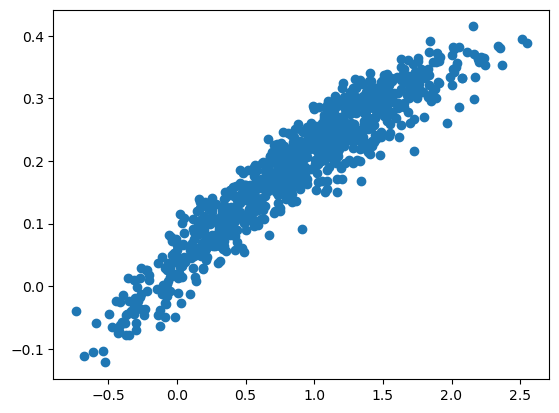

In [108]:
shot_preds = draft_df[['Name', 'Year', 'Draft Team', 'Team', 'Position', 'Pick']]
shot_preds['yhat 3PM'] = tpm_lasso.predict(X)
shot_preds['yhat 3P%'] = tpp_lasso.predict(X)
plt.scatter(shot_preds['yhat 3PM'], shot_preds['yhat 3P%'])

# EDA - Defense

## Defense

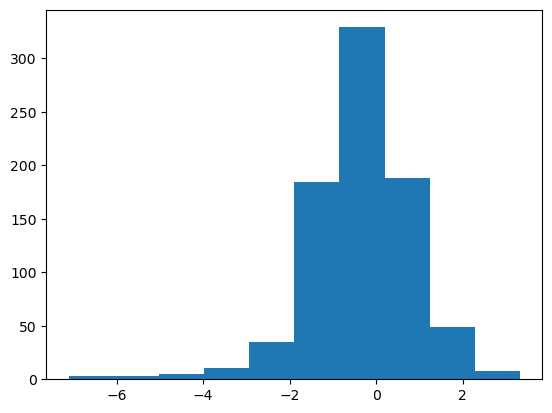

In [109]:
plt.hist(draft_df["NBA_DBPM"])
plt.show()

In [110]:
draft_df['NBA_DBPM'].describe()

count    815.000000
mean      -0.353259
std        1.209224
min       -7.100000
25%       -0.980118
50%       -0.307201
75%        0.339065
max        3.318528
Name: NBA_DBPM, dtype: float64

In [111]:
draft_df[draft_df['NBA_G'] <= 100]['NBA_DBPM'].mean()

-0.9790798146146764

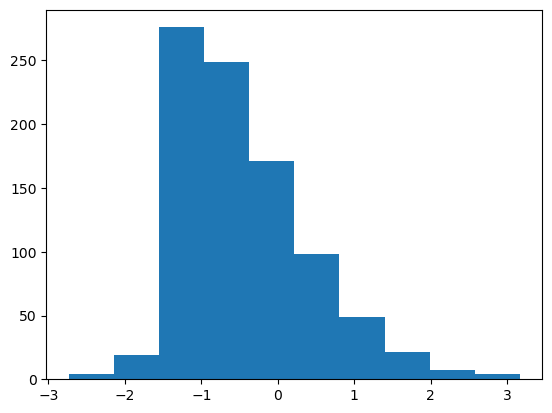

count    898.000000
mean      -0.421550
std        0.826786
min       -2.730708
25%       -1.000000
50%       -0.624854
75%        0.015227
max        3.162401
Name: Adj_NBA_DBPM, dtype: float64

In [112]:
DEFAULT_DBPM = -1

draft_df['NBA_DBPM'] = draft_df['NBA_DBPM'].fillna(DEFAULT_DBPM)
draft_df['Adj_NBA_DBPM'] = DEFAULT_DBPM + (draft_df['NBA_DBPM'] - DEFAULT_DBPM) * (1 - np.exp(-draft_df['NBA_G'] / 100))

plt.hist(draft_df['Adj_NBA_DBPM'])
plt.show()

draft_df['Adj_NBA_DBPM'].describe()

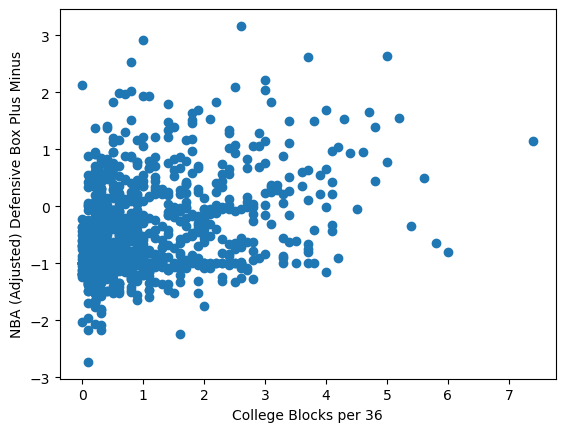

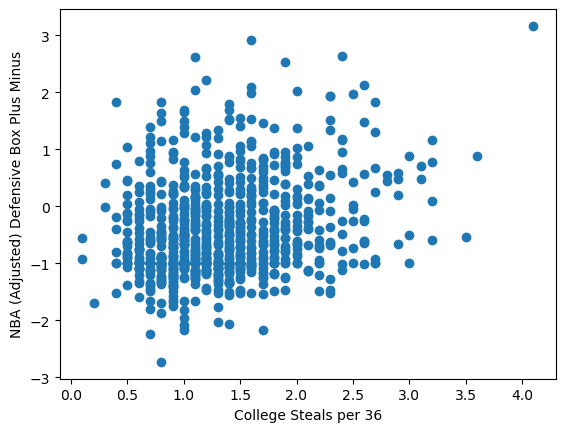

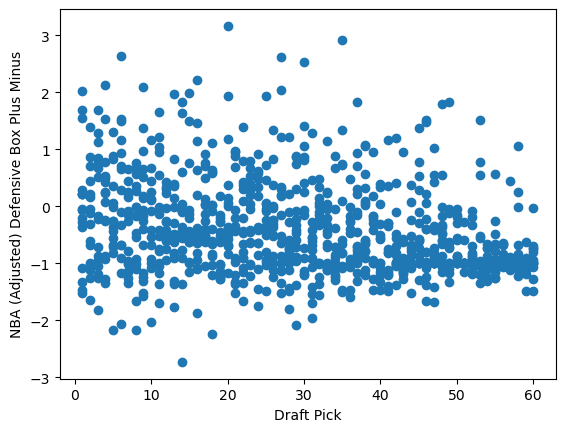

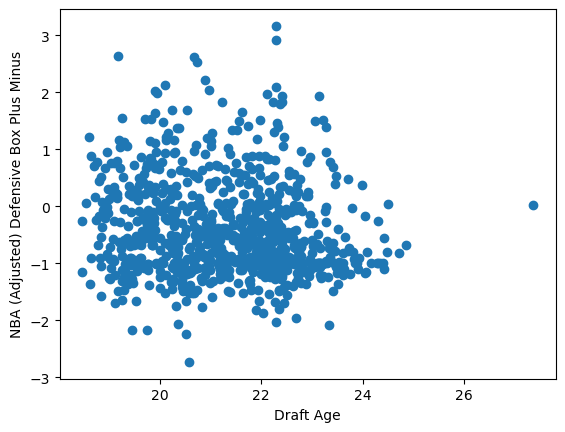

In [113]:
plt.scatter(draft_df['BLK'], draft_df['Adj_NBA_DBPM'])
plt.xlabel("College Blocks per 36")
plt.ylabel("NBA (Adjusted) Defensive Box Plus Minus")
plt.show()

plt.scatter(draft_df['STL'], draft_df['Adj_NBA_DBPM'])
plt.xlabel("College Steals per 36")
plt.ylabel("NBA (Adjusted) Defensive Box Plus Minus")
plt.show()

plt.scatter(draft_df['Pick'], draft_df['Adj_NBA_DBPM'])
plt.xlabel("Draft Pick")
plt.ylabel("NBA (Adjusted) Defensive Box Plus Minus")
plt.show()

plt.scatter(draft_df['Draft Age'], draft_df['Adj_NBA_DBPM'])
plt.xlabel("Draft Age")
plt.ylabel("NBA (Adjusted) Defensive Box Plus Minus")
plt.show()

## Rebounding

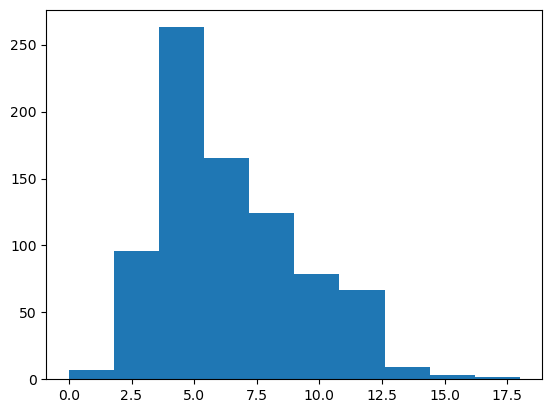

In [114]:
plt.hist(draft_df["NBA_REB_36"])
plt.show()

In [115]:
draft_df['NBA_REB_36'].describe()

count    815.000000
mean       6.411239
std        2.787007
min        0.000000
25%        4.195190
50%        5.750429
75%        8.258665
max       18.000000
Name: NBA_REB_36, dtype: float64

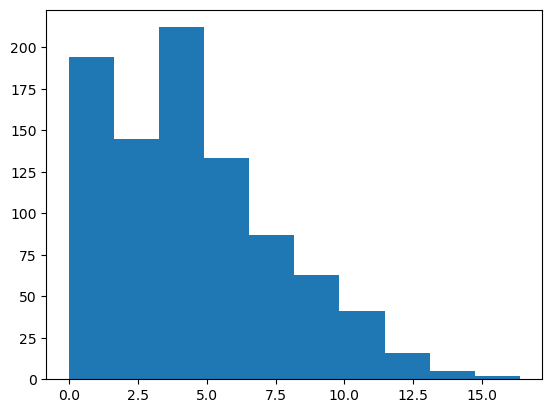

count    898.000000
mean       4.465102
std        3.222093
min        0.000000
25%        2.034744
50%        4.037431
75%        6.334587
max       16.365761
Name: Adj_NBA_REB_36, dtype: float64

In [116]:
draft_df['NBA_REB_36'] = draft_df['NBA_REB_36'].fillna(0)
draft_df['Adj_NBA_REB_36'] = draft_df['NBA_REB_36'] * (1 - np.exp(-draft_df['NBA_G'] / 100))

plt.hist(draft_df['Adj_NBA_REB_36'])
plt.show()

draft_df['Adj_NBA_REB_36'].describe()

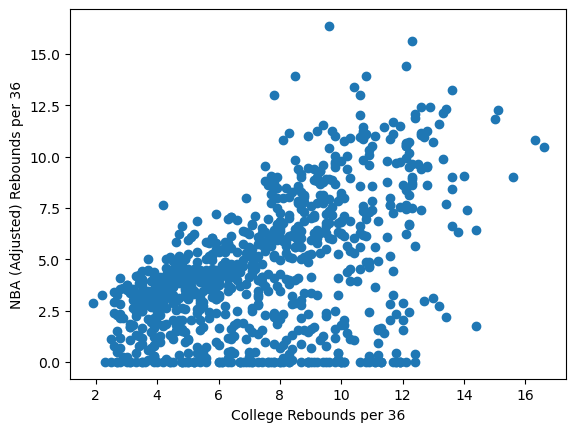

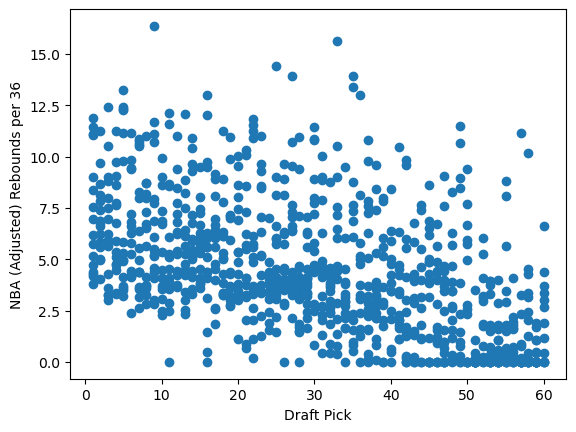

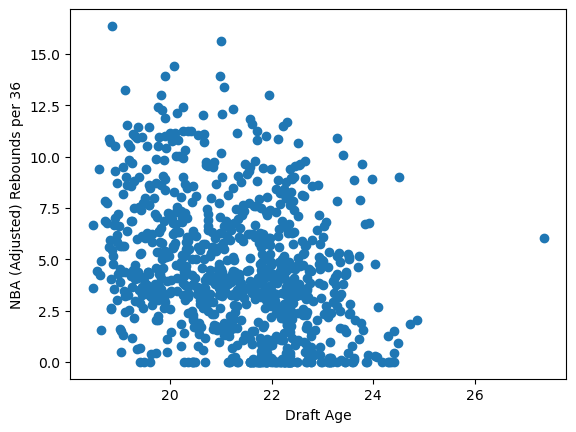

In [117]:
plt.scatter(draft_df['REB'], draft_df['Adj_NBA_REB_36'])
plt.xlabel("College Rebounds per 36")
plt.ylabel("NBA (Adjusted) Rebounds per 36")
plt.show()

plt.scatter(draft_df['Pick'], draft_df['Adj_NBA_REB_36'])
plt.xlabel("Draft Pick")
plt.ylabel("NBA (Adjusted) Rebounds per 36")
plt.show()

plt.scatter(draft_df['Draft Age'], draft_df['Adj_NBA_REB_36'])
plt.xlabel("Draft Age")
plt.ylabel("NBA (Adjusted) Rebounds per 36")
plt.show()

# Modeling - Defense

(array([  4.,  19., 276., 249., 171.,  98.,  49.,  21.,   7.,   4.]),
 array([-2.73070799, -2.14139708, -1.55208618, -0.96277527, -0.37346436,
         0.21584654,  0.80515745,  1.39446836,  1.98377927,  2.57309017,
         3.16240108]),
 <BarContainer object of 10 artists>)

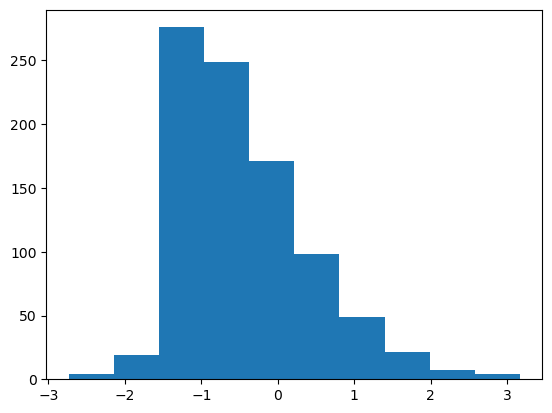

In [118]:
# create response vector
y_def = draft_df['Adj_NBA_DBPM']
# plot distribution
plt.hist(y_def)

(array([194., 145., 212., 133.,  87.,  63.,  41.,  16.,   5.,   2.]),
 array([ 0.        ,  1.63657611,  3.27315222,  4.90972834,  6.54630445,
         8.18288056,  9.81945667, 11.45603279, 13.0926089 , 14.72918501,
        16.36576112]),
 <BarContainer object of 10 artists>)

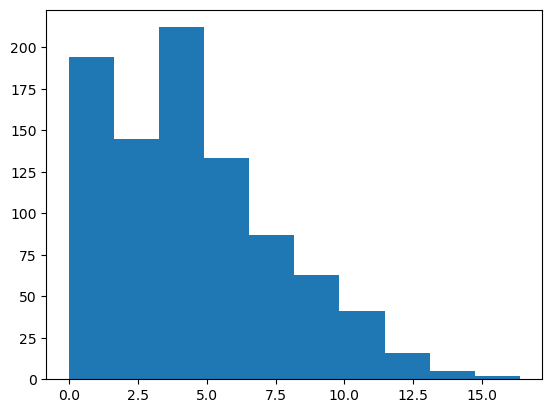

In [119]:
# response vector
y_reb = draft_df['Adj_NBA_REB_36']

# visualize new distribution of rebounds
plt.hist(y_reb)

In [120]:
y_def_train = y_def.loc[train_index]
y_def_test = y_def.loc[test_index]

y_reb_train = y_reb.loc[train_index]
y_reb_test = y_reb.loc[test_index]

In [121]:
models_def = {
    'Ridge' : {'model' : Ridge(random_state = 123),
               'grid' : {'alpha' : np.arange(10,100,5)},
               'grid_search' : True},
    'LASSO' : {'model' : Lasso(random_state = 123),
               'grid' : {'alpha' : np.arange(0.001, 0.010, 0.001)},
               'grid_search' : True},
    # 'Random Forest' : {'model' : RandomForestRegressor(random_state = 123),
    #                    'grid' : {'max_depth' : np.arange(1, 10, 1),
    #                              'min_samples_split' : [5, 10, 20],
    #                              'max_features' : [0.25, 0.5, 0.75, 1]},
    #                    'grid_search' : True},
    'MLP' : {'model' : MLPRegressor(random_state = 123, shuffle = True, max_iter = 1000, n_iter_no_change = 5),
             'grid' : {'activation' : ['relu', 'logistic'],
                       'hidden_layer_sizes' : [(x,) for x in np.arange(2,10,2)],
                       'learning_rate_init' : [0.1, 0.01]},
             'grid_search' : True},
    'SVM' : {'model' : SVR(),
             'grid' : {'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
                       'C' : np.arange(0.02, 0.20, 0.02)},
             'grid_search' : True},
    # 'XGB' : {'model' : XGBRegressor(random_state = 123),
    #          'grid' : {'n_estimators' : [100, 200, 500, 1000],
    #                    'max_depth' : np.arange(3, 11, 1),
    #                    'learning_rate' : [1e-4, 1e-3, 0.01, 0.1],
    #                    'subsample' : uniform(loc = 0.1, scale = 0.9),
    #                    'colsample_bytree' : uniform(loc = 0.1, scale = 0.9),
    #                    'colsample_bylevel' : uniform(loc = 0.1, scale = 0.9),
    #                    'reg_alpha' : uniform(loc = 0, scale = 1),
    #                    'reg_lambda' : uniform(loc = 0, scale = 1)},
    #          'grid_search' : False}
}

def_results = fitManyModels(models_def, X_train, X_test, y_def_train, y_def_test, cv = cv, classifier = False)

----------RIDGE----------
Best parameters: {'alpha': 45}
Train Loss: 0.41648176007658216
Validation Loss: 0.47156110072140267
----------LASSO----------


/Users/ayushbatra/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.575e+01, tolerance: 4.050e-02

/Users/ayushbatra/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.270e+00, tolerance: 4.011e-02

/Users/ayushbatra/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.041e+00, tolerance: 4.388e-02

/Users/ayushbatra/anacond

Best parameters: {'alpha': 0.004}
Train Loss: 0.41083301896937113
Validation Loss: 0.4718164727532995
----------MLP----------
Best parameters: {'activation': 'logistic', 'hidden_layer_sizes': (2,), 'learning_rate_init': 0.01}
Train Loss: 0.3795126316747086
Validation Loss: 0.538312992083463
----------SVM----------
Best parameters: {'C': 0.04, 'kernel': 'linear'}
Train Loss: 0.42327347994330583
Validation Loss: 0.47816336750007393


In [122]:
def_lasso = Double_Lasso()
def_lasso.fit_all(X_train, X_test, y_def_train, y_def_test, 
                  grid = models_def['LASSO']['grid'], cv = cv, n = 0.1)

Fitting initial model...


/Users/ayushbatra/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.575e+01, tolerance: 4.050e-02

/Users/ayushbatra/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.270e+00, tolerance: 4.011e-02

/Users/ayushbatra/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.041e+00, tolerance: 4.388e-02

/Users/ayushbatra/anacond

Best parameters: {'alpha': 0.004}
Train Loss: 0.41083301896937113
Validation Loss: 0.4718164727532995

Fitting reduced model...


/Users/ayushbatra/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.863e-02, tolerance: 4.050e-02

/Users/ayushbatra/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.253e-01, tolerance: 4.388e-02

/Users/ayushbatra/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.855e-02, tolerance: 3.932e-02

/Users/ayushbatra/anacond

Best parameters: {'alpha': 0.001}
Train Loss: 0.40845836448836415
Validation Loss: 0.45272407244817414


/Users/ayushbatra/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.457e-02, tolerance: 5.100e-02



In [123]:
models_reb = {
    'Ridge' : {'model' : Ridge(random_state = 123),
               'grid' : {'alpha' : np.arange(10,200,10)},
               'grid_search' : True},
    'LASSO' : {'model' : Lasso(random_state = 123),
               'grid' : {'alpha' : np.arange(0.01, 0.10, 0.01)},
               'grid_search' : True},
    # 'Random Forest' : {'model' : RandomForestRegressor(random_state = 123),
    #                    'grid' : {'max_depth' : np.arange(1, 10, 1),
    #                              'min_samples_split' : [5, 10, 20],
    #                              'max_features' : [0.25, 0.5, 0.75, 1]},
    #                    'grid_search' : True},
    'MLP' : {'model' : MLPRegressor(random_state = 123, shuffle = True, max_iter = 1000, n_iter_no_change = 5),
             'grid' : {'activation' : ['relu', 'logistic'],
                       'hidden_layer_sizes' : [(x,) for x in np.arange(2,10,2)],
                       'learning_rate_init' : [0.1, 0.01]},
             'grid_search' : True},
    'SVM' : {'model' : SVR(),
             'grid' : {'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
                       'C' : np.arange(0.02, 0.20, 0.02)},
             'grid_search' : True},
    # 'XGB' : {'model' : XGBRegressor(random_state = 123),
    #          'grid' : {'n_estimators' : [100, 200, 500, 1000],
    #                    'max_depth' : np.arange(3, 11, 1),
    #                    'learning_rate' : [1e-4, 1e-3, 0.01, 0.1],
    #                    'subsample' : uniform(loc = 0.1, scale = 0.9),
    #                    'colsample_bytree' : uniform(loc = 0.1, scale = 0.9),
    #                    'colsample_bylevel' : uniform(loc = 0.1, scale = 0.9),
    #                    'reg_alpha' : uniform(loc = 0, scale = 1),
    #                    'reg_lambda' : uniform(loc = 0, scale = 1)},
    #          'grid_search' : False}
}

reb_results = fitManyModels(models_reb, X_train, X_test, y_reb_train, y_reb_test, cv = cv, classifier = False)

----------RIDGE----------
Best parameters: {'alpha': 50}
Train Loss: 4.949059152107741
Validation Loss: 5.603323772146462
----------LASSO----------


/Users/ayushbatra/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.424e+00, tolerance: 6.455e-01



Best parameters: {'alpha': 0.04}
Train Loss: 5.021522576921042
Validation Loss: 5.437636114792556
----------MLP----------


/Users/ayushbatra/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.

/Users/ayushbatra/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.

/Users/ayushbatra/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.

/Users/ayushbatra/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.

/Users/ayushbatra/anaconda3/lib/python3.11/site-packages/sklearn/neural_

Best parameters: {'activation': 'relu', 'hidden_layer_sizes': (2,), 'learning_rate_init': 0.1}
Train Loss: 4.573048615265375
Validation Loss: 6.088710957066021
----------SVM----------
Best parameters: {'C': 0.16, 'kernel': 'linear'}
Train Loss: 5.023511075614771
Validation Loss: 5.661660804729374


In [124]:
reb_lasso = Double_Lasso()
reb_lasso.fit_all(X_train, X_test, y_reb_train, y_reb_test,
                  grid = models_reb['LASSO']['grid'], cv = cv, n = 0.1)

Fitting initial model...


/Users/ayushbatra/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.424e+00, tolerance: 6.455e-01



Best parameters: {'alpha': 0.04}
Train Loss: 5.021522576921042
Validation Loss: 5.437636114792556

Fitting reduced model...
Best parameters: {'alpha': 0.01}
Train Loss: 5.062500341958036
Validation Loss: 5.181389405964916


In [125]:
def_lasso.display_features()

Feature      Coef
10     log_AST/USG  0.390654
0          log_AST  0.202765
9              PER  0.199878
4              STL  0.175982
12  PTS_x_log_pick  0.162749
8           log_MP  0.161747
7             DBPM  0.160572
6              REB  0.153263
13           Fouls  0.137645
11        Wingspan  0.134111
17       BLK_x_STL  0.067775
22     na_advanced  0.045415
23               C  0.042544
25      log_AST/TO  0.013389
21              TO -0.041203
20             BMI -0.048509
16       3P%_x_PTS -0.074290
24            3PAr -0.074312
19       Draft Age -0.077693
15              PF -0.084683
18          DWS/40 -0.096089
5              AST -0.111172
14             2PA -0.147336
1              PTS -0.213171
2             Pick -0.221740
3          AST/USG -0.523108

In [126]:
reb_lasso.display_features()

Feature      Coef
1             REB  1.023418
6  AST_x_log_pick  0.556969
3               C  0.457511
7           WS/40  0.397082
5          log_MP  0.236209
4       Draft Age -0.372362
2       3P%_x_PTS -0.377242
8       PTS_x_AST -0.573998
0            Pick -1.469019

In [127]:
def_lasso.full_predict(draft_df, X, y_def).head(10)

Name  Year Draft Team        Team Position  Pick  \
473         Nerlens Noel  2013        PHI    Kentucky        C     6   
804     Matisse Thybulle  2019        PHI  Washington       SF    20   
413        Anthony Davis  2012         NO    Kentucky     PF/C     1   
526          Joel Embiid  2014        PHI      Kansas        C     3   
486         Gorgui Dieng  2013        MIN  Louisville        C    21   
145          Joakim Noah  2007        CHI     Florida        C     9   
314         Cole Aldrich  2010        OKC      Kansas        C    11   
580  Willie Cauley-Stein  2015        SAC    Kentucky        C     6   
89          Tyrus Thomas  2006        CHI         LSU       PF     4   
660       Chinanu Onuaku  2016        HOU  Louisville        C    37   

     Predicted      Real  
473   2.414845  2.640280  
804   1.933241  3.162401  
413   1.497421  1.539699  
526   1.234884  1.688945  
486   1.172648  0.685146  
145   1.053761  2.086709  
314   0.899792  1.655491  
580   0.898477  0.660280  
89    0.886207  1.535358  
660   0.875208 -0.913906

In [128]:
reb_lasso.full_predict(draft_df, X, y_reb).head(10)

Name  Year Draft Team               Team Position  Pick  \
308    DeMarcus Cousins  2010        SAC           Kentucky        C     5   
0          Emeka Okafor  2004        CHA              UConn        C     2   
138           Greg Oden  2007        POR         Ohio State        C     1   
247     Hasheem Thabeet  2009        MEM              UConn        C     2   
41         Andrew Bogut  2005        MIL               Utah        C     1   
363   Jonas Valanciunas  2011        TOR  Rytas (Lithuania)        C     5   
413       Anthony Davis  2012         NO           Kentucky     PF/C     1   
246       Blake Griffin  2009        LAC           Oklahoma       PF     1   
575  Karl-Anthony Towns  2015        MIN           Kentucky        C     1   
733       DeAndre Ayton  2018        PHX            Arizona        C     1   

     Predicted       Real  
308  11.607609  12.279960  
0    11.379059  11.249450  
138  11.145751   7.569956  
247  11.085950   8.120347  
41   11.037897  11.068525  
363  10.837195  13.225023  
413  10.653280  11.080985  
246  10.578614   9.014899  
575  10.529609  11.464887  
733  10.404151  11.894247

In [129]:
def_lasso.full_predict(recent_df, X_r).head(10)

Name  Year Draft Team               Team Position  Pick  \
79     Walker Kessler  2022        MIN             Auburn        C    22   
126  Dereck Lively II  2023        DAL               Duke        C    12   
14     Alperen Şengün  2021        HOU  Beşiktaş (Turkey)        C    16   
37      Neemias Queta  2021        SAC         Utah State        C    39   
20     Isaiah Jackson  2021        IND           Kentucky     PF/C    22   
60      Chet Holmgren  2022        OKC            Gonzaga        C     2   
72      Mark Williams  2022        CHA               Duke        C    15   
90   Christian Koloko  2022        TOR            Arizona        C    33   
70        Jalen Duren  2022        DET            Memphis        C    13   
6        Franz Wagner  2021        ORL           Michigan       SF     8   

     Predicted  
79    1.414900  
126   1.354496  
14    0.979511  
37    0.972066  
20    0.942818  
60    0.905476  
72    0.839401  
90    0.720633  
70    0.623770  
6     0.586195

In [130]:
reb_lasso.full_predict(recent_df, X_r).head(10)

Name  Year Draft Team                       Team Position  \
60       Chet Holmgren  2022        OKC                    Gonzaga        C   
70         Jalen Duren  2022        DET                    Memphis        C   
72       Mark Williams  2022        CHA                       Duke        C   
1          Evan Mobley  2021        CLE                        USC        C   
14      Alperen Şengün  2021        HOU          Beşiktaş (Turkey)        C   
115  Victor Wembanyama  2023         SA  Metropolitans 92 (France)        C   
126   Dereck Lively II  2023        DAL                       Duke        C   
27      Day'Ron Sharpe  2021        BKN             North Carolina        C   
79      Walker Kessler  2022        MIN                     Auburn        C   
20      Isaiah Jackson  2021        IND                   Kentucky     PF/C   

     Pick  Predicted  
60      2  10.155339  
70     13   9.688844  
72     15   9.479384  
1       3   9.277845  
14     16   9.244190  
115     1   9.014852  
126    12   8.873956  
27     29   8.561232  
79     22   8.452147  
20     22   7.819432

In [131]:
def_lasso.full_predict(draft24, X_24).head(10)

Name  Year  Draft Team           Team Position  Pick  Predicted
6   Donovan Clingan  2024         NaN          UConn        C   3.8   0.717255
38   Jonathan Mogbo  2024         NaN  San Francisco       PF  40.6   0.604580
1     Reed Sheppard  2024         NaN       Kentucky    PG/SG   3.4   0.601600
32        Ryan Dunn  2024         NaN       Virginia       SF  29.0   0.553418
64     N'Faly Dante  2024         NaN         Oregon        C  65.2   0.521606
43        Adem Bona  2024         NaN           UCLA        C  38.6   0.417291
16  Kyle Filipowski  2024         NaN           Duke        C  21.6   0.379454
25        Zach Edey  2024         NaN         Purdue        C  19.4   0.255605
18      Kel'el Ware  2024         NaN        Indiana        C  21.8   0.178324
12     Devin Carter  2024         NaN     Providence       PG  10.6   0.136867

In [132]:
reb_lasso.full_predict(draft24, X_24).head(10)

Name  Year  Draft Team           Team Position  Pick  Predicted
6   Donovan Clingan  2024         NaN          UConn        C   3.8  10.238478
25        Zach Edey  2024         NaN         Purdue        C  19.4   9.778408
18      Kel'el Ware  2024         NaN        Indiana        C  21.8   7.855852
21       Yves Missi  2024         NaN         Baylor        C  22.0   7.518210
3    Alexandre Sarr  2024         NaN    Perth (NBL)     PF/C   3.0   7.409456
16  Kyle Filipowski  2024         NaN           Duke        C  21.6   7.294535
38   Jonathan Mogbo  2024         NaN  San Francisco       PF  40.6   6.305506
5    Stephon Castle  2024         NaN          UConn    PG/SG   4.6   6.133683
4     Matas Buzelis  2024         NaN       G League       SF   5.6   6.130589
12     Devin Carter  2024         NaN     Providence       PG  10.6   5.670195

In [133]:
print(f"DBPM Model Test Set Score: {def_lasso.score(X_test, y_def_test)}")
print(f"Rebounds Model Test Set Score: {reb_lasso.score(X_test, y_reb_test)}")

DBPM Model Test Set Score: 0.3950148238303165
Rebounds Model Test Set Score: 0.41668673720802973


In [134]:
pl = ['Dalton Knecht', 'Zaccharie Risacher', 'Rob Dillingham']
pl = ['Donovan Clingan', 'Reed Sheppard', 'Devin Carter']
va = ['log_AST/USG', 'log_AST', 'PER', 'STL', 'PTS_x_log_pick', 'log_MP', 'DBPM', 'PTS', 'Pick', 'AST/USG', 'BLK', 'BLK_x_STL']
ind = draft24[draft24['Name'].isin(pl)].index.tolist()
temp = X_24.loc[ind][va]
temp.index = draft24.loc[ind]['Name'].tolist()
temp

log_AST/USG   log_AST       PER       STL  PTS_x_log_pick  \
Reed Sheppard       3.385757  1.499423 -0.016540  3.049676       -1.920812   
Donovan Clingan     0.421076 -0.011842  2.162810 -0.936579       -1.439494   
Devin Carter        1.643699  0.725882  0.372629  0.796575       -0.362750   

                   log_MP      DBPM       PTS      Pick   AST/USG       BLK  \
Reed Sheppard   -0.073619  1.368873 -0.586276 -1.549906  1.905107 -0.223970   
Donovan Clingan -1.146228  2.130830  0.915586 -1.526582 -0.247102  2.500095   
Devin Carter     0.783528  1.368873  0.717227 -1.130075  0.533074 -0.133168   

                 BLK_x_STL  
Reed Sheppard     1.041230  
Donovan Clingan   1.282955  
Devin Carter      0.316056

In [135]:
tmp = def_lasso.full_predict(draft24, X_24)
tmp.sort_values('Pick').head(20)

Name  Year  Draft Team                    Team Position  \
3       Alexandre Sarr  2024         NaN             Perth (NBL)     PF/C   
2   Zaccharie Risacher  2024         NaN       JL Bourg (France)       SF   
1        Reed Sheppard  2024         NaN                Kentucky    PG/SG   
6      Donovan Clingan  2024         NaN                   UConn        C   
5       Stephon Castle  2024         NaN                   UConn    PG/SG   
4        Matas Buzelis  2024         NaN                G League       SF   
7        Dalton Knecht  2024         NaN               Tennessee       SF   
0         Nikola Topić  2024         NaN       Red Star (Serbia)       PG   
8       Rob Dillingham  2024         NaN                Kentucky       PG   
10      Tidjane Salaun  2024         NaN  Cholet Basket (France)       SF   
12        Devin Carter  2024         NaN              Providence       PG   
11       Cody Williams  2024         NaN                Colorado       SF   
9          Ron Holland  2024         NaN                G League    SF/PF   
13        Jared McCain  2024         NaN                    Duke    PG/SG   
14      Ja'Kobe Walter  2024         NaN                  Baylor       SG   
15    Tristan da Silva  2024         NaN                Colorado    SF/PF   
19      Isaiah Collier  2024         NaN                     USC       PG   
25           Zach Edey  2024         NaN                  Purdue        C   
29  Carlton Carrington  2024         NaN              Pittsburgh       PG   
16     Kyle Filipowski  2024         NaN                    Duke        C   

    Pick  Predicted  
3    3.0  -0.302537  
2    3.2  -0.748885  
1    3.4   0.601600  
6    3.8   0.717255  
5    4.6  -0.131901  
4    5.6  -0.228146  
7    7.4  -1.398850  
0    8.4  -0.310604  
8    8.8  -0.854288  
10  10.0  -0.422396  
12  10.6   0.136867  
11  10.8  -0.594143  
9   11.8  -0.115183  
13  14.4  -0.716988  
14  15.4  -0.628475  
15  19.0  -0.641117  
19  19.2  -0.770231  
25  19.4   0.255605  
29  20.2  -0.469452  
16  21.6   0.379454

# All Predictions

In [136]:
# Aggregate all predictions

final_models = {
    'PTS' : pts_lasso,
    'AST' : ast_lasso,
    'TS%' : tsp_lasso,
    'TOV%' : tov_lasso,
    '3PM' : tpm_lasso,
    'DBPM' : def_lasso,
}

def addAllPredictions(draft_df, X, final_models):
    id_info = draft_df[['Name', 'Year', 'Draft Team', 'Team', 'Position', 'Pick', 'Height', 'Wingspan']]
    predictions = {key : model.predict(X) for key, model in final_models.items()}
    for p, vec in predictions.items():
        id_info['yhat ' + p] = vec
    return id_info

proj = addAllPredictions(draft_df, X, final_models)
proj_r = addAllPredictions(recent_df, X_r, final_models)
proj24 = addAllPredictions(draft24, X_24, final_models)
proj_all = pd.concat([proj, proj_r, proj24])
proj_all = proj_all.reset_index(drop = True)

In [137]:
# Generate percentiles for all predictions

for var in final_models.keys():
    if var == 'TOV%':
        proj_all['Pct ' + var] = np.round(100 * proj_all['yhat ' + var].rank(pct = True, ascending = False), 1)
    else:
        proj_all['Pct ' + var] = np.round(100 * proj_all['yhat ' + var].rank(pct = True), 1)
        
proj_all['Pct Score'] = proj_all['yhat TS%'] * proj_all['yhat PTS']
proj_all['Pct Score'] = np.round(100 * proj_all['Pct Score'].rank(pct = True), 1)

proj_all['Pct Play'] = proj_all['yhat AST'] / proj_all['yhat TOV%']
proj_all['Pct Play'] = np.round(100 * proj_all['Pct Play'].rank(pct = True), 1)

proj_all['Create'] = np.round(np.sqrt(proj_all['Pct Score'] * proj_all['Pct Play']), 1)

In [138]:
# See stats for 2024
proj_all[proj_all['Year'] == 2024].sort_values('Pick').head(60)

Name  Year Draft Team                      Team  \
1074        Alexandre Sarr  2024        NaN               Perth (NBL)   
1073    Zaccharie Risacher  2024        NaN         JL Bourg (France)   
1072         Reed Sheppard  2024        NaN                  Kentucky   
1077       Donovan Clingan  2024        NaN                     UConn   
1076        Stephon Castle  2024        NaN                     UConn   
1075         Matas Buzelis  2024        NaN                  G League   
1078         Dalton Knecht  2024        NaN                 Tennessee   
1071          Nikola Topić  2024        NaN         Red Star (Serbia)   
1079        Rob Dillingham  2024        NaN                  Kentucky   
1081        Tidjane Salaun  2024        NaN    Cholet Basket (France)   
1083          Devin Carter  2024        NaN                Providence   
1082         Cody Williams  2024        NaN                  Colorado   
1080           Ron Holland  2024        NaN                  G League   
1084          Jared McCain  2024        NaN                      Duke   
1085        Ja'Kobe Walter  2024        NaN                    Baylor   
1086      Tristan da Silva  2024        NaN                  Colorado   
1090        Isaiah Collier  2024        NaN                       USC   
1096             Zach Edey  2024        NaN                    Purdue   
1100    Carlton Carrington  2024        NaN                Pittsburgh   
1087       Kyle Filipowski  2024        NaN                      Duke   
1089           Kel'el Ware  2024        NaN                   Indiana   
1092            Yves Missi  2024        NaN                    Baylor   
1088         Johnny Furphy  2024        NaN                    Kansas   
1094           Tyler Kolek  2024        NaN                 Marquette   
1097        Kyshawn George  2024        NaN                     Miami   
1093           Tyler Smith  2024        NaN                  G League   
1091  Terrence Shannon Jr.  2024        NaN                  Illinois   
1098         Bobi Klintman  2024        NaN              Cairns (NBL)   
1095       DaRon Holmes II  2024        NaN                    Dayton   
1099     Baylor Scheierman  2024        NaN                 Creighton   
1103             Ryan Dunn  2024        NaN                  Virginia   
1102         Pacome Dadiet  2024        NaN  Ratiopharm Ulm (Germany)   
1101          Jaylon Tyson  2024        NaN                California   
1104        Kevin McCullar  2024        NaN                    Kansas   
1108          Cam Christie  2024        NaN                 Minnesota   
1114             Adem Bona  2024        NaN                      UCLA   
1111        Justin Edwards  2024        NaN                  Kentucky   
1109        Jonathan Mogbo  2024        NaN             San Francisco   
1112       Nikola Djurisic  2024        NaN   KK Mega Basket (Serbia)   
1105            Juan Núñez  2024        NaN  Ratiopharm Ulm (Germany)   
1118       Harrison Ingram  2024        NaN            North Carolina   
1106            AJ Johnson  2024        NaN           Illawarra (NBL)   
1115            KJ Simpson  2024        NaN                  Colorado   
1107         Ajay Mitchell  2024        NaN          UC Santa Barbara   
1117           Jamal Shead  2024        NaN                   Houston   
1113          Dillon Jones  2024        NaN               Weber State   
1110          Oso Ighodaro  2024        NaN                 Marquette   
1122         Melvin Ajinca  2024        NaN    Saint-Quentin (France)   
1119          Jaylen Wells  2024        NaN          Washington State   
1123           Cam Spencer  2024        NaN                     UConn   
1116         Pelle Larsson  2024        NaN                   Arizona   
1121        Keshad Johnson  2024        NaN                   Arizona   
1120        Trey Alexander  2024        NaN                 Creighton   
1124         Jalen Bridges  2024        NaN                    Baylor   
1129   

In [139]:
# calculate average percent rank for each group of draft picks
proj_all['Bin'] = pd.cut(proj_all['Pick'], bins = [0, 5, 10, 15, 30, 45, 100])
p_cols = [c for c in proj_all if c[:3] == 'Pct'] + ['Create']
proj_avg = proj_all.groupby(['Bin'])[p_cols].mean()
proj_avg

/var/folders/kf/vfp2zjg504g1psqvfpcfzcvw0000gn/T/ipykernel_41107/2267570195.py:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Pct PTS    Pct AST    Pct TS%   Pct TOV%    Pct 3PM   Pct DBPM  \
Bin                                                                           
(0, 5]     93.259794  76.046392  86.468041  50.676289  66.617526  66.587629   
(5, 10]    85.900000  73.956701  79.292784  58.639175  71.157732  63.896907   
(10, 15]   77.778125  65.708333  74.612500  64.462500  68.275000  56.775000   
(15, 30]   61.167568  59.664865  59.766892  54.123986  57.951689  57.787500   
(30, 45]   36.309058  42.222464  38.239130  46.182971  42.294928  45.773188   
(45, 100]  14.541155  24.648014  19.903971  41.302527  29.798917  33.047292   

           Pct Score   Pct Play     Create  
Bin                                         
(0, 5]     93.128866  77.270103  83.727835  
(5, 10]    85.701031  75.498969  79.722680  
(10, 15]   77.837500  68.653125  72.443750  
(15, 30]   61.221284  60.046284  59.736149  
(30, 45]   36.387681  41.250362  37.382971  
(45, 100]  14.500361  23.219856  16.995307

In [140]:
# calculate summary of creation percent rank for each group of draft picks
proj_ovr = proj_all.groupby(['Bin'])['Create'].describe()
proj_ovr

/var/folders/kf/vfp2zjg504g1psqvfpcfzcvw0000gn/T/ipykernel_41107/353627789.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



count       mean        std   min     25%    50%     75%   max
Bin                                                                      
(0, 5]      97.0  83.727835  14.068358  32.7  76.300  88.60  93.600  99.7
(5, 10]     97.0  79.722680  12.257154  38.3  74.900  81.10  89.800  97.9
(10, 15]    96.0  72.443750  13.788842  41.1  63.250  75.65  83.625  95.2
(15, 30]   296.0  59.736149  15.105626  15.8  49.650  59.90  71.675  90.1
(30, 45]   276.0  37.382971  15.272412   1.9  26.775  36.80  46.850  78.9
(45, 100]  277.0  16.995307  12.557451   0.4   6.900  14.30  24.700  60.5

In [141]:
# limit columns for better presentation
composite = proj_all[id_cols + ['Pick', 'Height', 'Wingspan'] + p_cols]
# calculate a "3 and D" score
composite['3+D'] = np.round((composite['Pct 3PM'] + composite['Pct DBPM']) / 2, 1)

# convert Ht and Wingspan into inches above 6 ft
composite['Height'] = composite['Height'] - 72
composite['Wingspan'] = composite['Wingspan'] - 72


# create flags for small players
# these models seem to favor smaller players, but in reality smaller players can't hold up on defense usually so want to flag them

# create a flag for players with small size (smaller than 6'6")
size_cond1 = (composite['Wingspan'].isnull()) & (composite['Height'] < 6)
size_cond2 = (composite['Wingspan'].notnull()) & (composite['Height'] + composite['Wingspan'] < 12)
composite['Size'] = np.where(size_cond1 | size_cond2, "X", "")

# create a flag for players with very small size (smaller than 6'4")
size_cond3 = (composite['Wingspan'].isnull()) & (composite['Height'] < 4)
size_cond4 = (composite['Wingspan'].notnull()) & (composite['Height'] + composite['Wingspan'] < 8)
composite['Size'] = np.where(size_cond3 | size_cond4, "XX", composite['Size'])

In [142]:
# view stats for 2024 prospects
c1 = (composite['Pick'] > 0) & (composite['Pick'] <= 100)
c2 = (composite['Year'] == 2024)
composite[c1 & c2].sort_values('Create', ascending = False).head(60)

Name  Year Draft Team                      Team  \
1072         Reed Sheppard  2024        NaN                  Kentucky   
1079        Rob Dillingham  2024        NaN                  Kentucky   
1071          Nikola Topić  2024        NaN         Red Star (Serbia)   
1076        Stephon Castle  2024        NaN                     UConn   
1084          Jared McCain  2024        NaN                      Duke   
1077       Donovan Clingan  2024        NaN                     UConn   
1083          Devin Carter  2024        NaN                Providence   
1080           Ron Holland  2024        NaN                  G League   
1090        Isaiah Collier  2024        NaN                       USC   
1100    Carlton Carrington  2024        NaN                Pittsburgh   
1075         Matas Buzelis  2024        NaN                  G League   
1073    Zaccharie Risacher  2024        NaN         JL Bourg (France)   
1078         Dalton Knecht  2024        NaN                 Tennessee   
1087       Kyle Filipowski  2024        NaN                      Duke   
1074        Alexandre Sarr  2024        NaN               Perth (NBL)   
1082         Cody Williams  2024        NaN                  Colorado   
1094           Tyler Kolek  2024        NaN                 Marquette   
1085        Ja'Kobe Walter  2024        NaN                    Baylor   
1081        Tidjane Salaun  2024        NaN    Cholet Basket (France)   
1088         Johnny Furphy  2024        NaN                    Kansas   
1086      Tristan da Silva  2024        NaN                  Colorado   
1115            KJ Simpson  2024        NaN                  Colorado   
1089           Kel'el Ware  2024        NaN                   Indiana   
1093           Tyler Smith  2024        NaN                  G League   
1117           Jamal Shead  2024        NaN                   Houston   
1108          Cam Christie  2024        NaN                 Minnesota   
1097        Kyshawn George  2024        NaN                     Miami   
1095       DaRon Holmes II  2024        NaN                    Dayton   
1101          Jaylon Tyson  2024        NaN                California   
1099     Baylor Scheierman  2024        NaN                 Creighton   
1096             Zach Edey  2024        NaN                    Purdue   
1105            Juan Núñez  2024        NaN  Ratiopharm Ulm (Germany)   
1091  Terrence Shannon Jr.  2024        NaN                  Illinois   
1092            Yves Missi  2024        NaN                    Baylor   
1102         Pacome Dadiet  2024        NaN  Ratiopharm Ulm (Germany)   
1107         Ajay Mitchell  2024        NaN          UC Santa Barbara   
1109        Jonathan Mogbo  2024        NaN             San Francisco   
1098         Bobi Klintman  2024        NaN              Cairns (NBL)   
1119          Jaylen Wells  2024        NaN          Washington State   
1103             Ryan Dunn  2024        NaN                  Virginia   
1111        Justin Edwards  2024        NaN                  Kentucky   
1123           Cam Spencer  2024        NaN                     UConn   
1104        Kevin McCullar  2024        NaN                    Kansas   
1112       Nikola Djurisic  2024        NaN   KK Mega Basket (Serbia)   
1118       Harrison Ingram  2024        NaN            North Carolina   
1114             Adem Bona  2024        NaN                      UCLA   
1110          Oso Ighodaro  2024        NaN                 Marquette   
1113          Dillon Jones  2024        NaN               Weber State   
1122         Melvin Ajinca  2024        NaN    Saint-Quentin (France)   
1116         Pelle Larsson  2024        NaN                   Arizona   
1136           Judah Mintz  2024        NaN                  Syracuse   
1120        Trey Alexander  2024        NaN                 Creighton   
1134         Reece Beekman  2024        NaN                  Virginia   
1126        Tristen Newton  2024        NaN                     UConn   
1124   

In [143]:
# View stats for 2024
composite[composite['Year'] == 2024].sort_values('Pick').head(60)

Name  Year Draft Team                      Team  \
1074        Alexandre Sarr  2024        NaN               Perth (NBL)   
1073    Zaccharie Risacher  2024        NaN         JL Bourg (France)   
1072         Reed Sheppard  2024        NaN                  Kentucky   
1077       Donovan Clingan  2024        NaN                     UConn   
1076        Stephon Castle  2024        NaN                     UConn   
1075         Matas Buzelis  2024        NaN                  G League   
1078         Dalton Knecht  2024        NaN                 Tennessee   
1071          Nikola Topić  2024        NaN         Red Star (Serbia)   
1079        Rob Dillingham  2024        NaN                  Kentucky   
1081        Tidjane Salaun  2024        NaN    Cholet Basket (France)   
1083          Devin Carter  2024        NaN                Providence   
1082         Cody Williams  2024        NaN                  Colorado   
1080           Ron Holland  2024        NaN                  G League   
1084          Jared McCain  2024        NaN                      Duke   
1085        Ja'Kobe Walter  2024        NaN                    Baylor   
1086      Tristan da Silva  2024        NaN                  Colorado   
1090        Isaiah Collier  2024        NaN                       USC   
1096             Zach Edey  2024        NaN                    Purdue   
1100    Carlton Carrington  2024        NaN                Pittsburgh   
1087       Kyle Filipowski  2024        NaN                      Duke   
1089           Kel'el Ware  2024        NaN                   Indiana   
1092            Yves Missi  2024        NaN                    Baylor   
1088         Johnny Furphy  2024        NaN                    Kansas   
1094           Tyler Kolek  2024        NaN                 Marquette   
1097        Kyshawn George  2024        NaN                     Miami   
1093           Tyler Smith  2024        NaN                  G League   
1091  Terrence Shannon Jr.  2024        NaN                  Illinois   
1098         Bobi Klintman  2024        NaN              Cairns (NBL)   
1095       DaRon Holmes II  2024        NaN                    Dayton   
1099     Baylor Scheierman  2024        NaN                 Creighton   
1103             Ryan Dunn  2024        NaN                  Virginia   
1102         Pacome Dadiet  2024        NaN  Ratiopharm Ulm (Germany)   
1101          Jaylon Tyson  2024        NaN                California   
1104        Kevin McCullar  2024        NaN                    Kansas   
1108          Cam Christie  2024        NaN                 Minnesota   
1114             Adem Bona  2024        NaN                      UCLA   
1111        Justin Edwards  2024        NaN                  Kentucky   
1109        Jonathan Mogbo  2024        NaN             San Francisco   
1112       Nikola Djurisic  2024        NaN   KK Mega Basket (Serbia)   
1105            Juan Núñez  2024        NaN  Ratiopharm Ulm (Germany)   
1118       Harrison Ingram  2024        NaN            North Carolina   
1106            AJ Johnson  2024        NaN           Illawarra (NBL)   
1115            KJ Simpson  2024        NaN                  Colorado   
1107         Ajay Mitchell  2024        NaN          UC Santa Barbara   
1117           Jamal Shead  2024        NaN                   Houston   
1113          Dillon Jones  2024        NaN               Weber State   
1110          Oso Ighodaro  2024        NaN                 Marquette   
1122         Melvin Ajinca  2024        NaN    Saint-Quentin (France)   
1119          Jaylen Wells  2024        NaN          Washington State   
1123           Cam Spencer  2024        NaN                     UConn   
1116         Pelle Larsson  2024        NaN                   Arizona   
1121        Keshad Johnson  2024        NaN                   Arizona   
1120        Trey Alexander  2024        NaN                 Creighton   
1124         Jalen Bridges  2024        NaN                    Baylor   
1129   

In [144]:
# make a "creation" and a "playmaking" stat
# for creation: multiply PTS and TS% bc want high values for both
# for playmaking: divide AST by TOV% bc want high AST and low TOV%
proj_all['yhat Create'] = proj_all['yhat PTS'] * proj_all['yhat TS%']
proj_all['yhat Play'] = proj_all['yhat AST'] / proj_all['yhat TOV%']

# create the same variables for the training set NBA stats
draft_df['Adj_Create'] = draft_df['Adj_NBA_PTS_36'] * draft_df['Adj_NBA_TS%']
draft_df['Adj_Play']= draft_df['Adj_NBA_AST_36'] / draft_df['Adj_NBA_TOV%']

In [145]:
# VIEW MOST SIMILAR NBA PLAYERS FOR A CERTAIN PROSPECT
# INDEX = index for the player in the proj_all dataframe
# OPTIMISTIC = True means compare the player's stats vs all college players
# OPTIMISTIC = False means compare the player's stats on raw NBA scale
# setting OPTIMISTIC to true usually leads to more flattering / impressive comps 
# gets most similar players using distance with 5 dimensions - creation, playmaking, shooting, defense, and height

INDEX = 1071
OPTIMISTIC = False

SKILLS = ['yhat Create', 'yhat Play', 'yhat 3PM', 'yhat DBPM', 'Height']
MATCH = ['Adj_Create', 'Adj_Play', 'Adj_NBA_3PM_36', 'Adj_NBA_DBPM', 'Height']
ps = proj_all.loc[INDEX][['Name'] + SKILLS]
ps2 = ps.copy()
draft_df2 = draft_df.copy()
draft_df2 = draft_df2[['Name', 'Year', 'Draft Team', 'Pick', 'Team'] + MATCH]
DIST = 0
for sk, ma in zip(SKILLS, MATCH):
    mean = draft_df[ma].mean()
    sd = draft_df[ma].std()
    if OPTIMISTIC:
        player_z = (ps.loc[sk] - proj_all[sk].mean()) / proj_all[sk].std()
    else:
        player_z = (ps.loc[sk] - mean) / sd
    field_z = (draft_df[ma] - mean) / sd
    ps2.loc[sk] = player_z
    draft_df2[ma] = field_z
    DIST += (field_z - player_z)**2
print(ps2)
draft_df2['dist'] = DIST
draft_df2.sort_values('dist').head(10)

Name           Nikola Topić
yhat Create         0.92146
yhat Play          2.389851
yhat 3PM           1.072349
yhat DBPM           0.13419
Height            -0.014103
Name: 1071, dtype: object


Name  Year Draft Team  Pick             Team  Adj_Create  \
556  Spencer Dinwiddie  2014        DET    38         Colorado    1.044622   
648       Caris LeVert  2016        BKN    20         Michigan    1.065306   
659    Malcolm Brogdon  2016        MIL    36         Virginia    1.385131   
850      Devin Vassell  2020         SA    11    Florida State    0.935440   
842        LaMelo Ball  2020        CHA     3  Illawarra (NBL)    1.235540   
262       Jrue Holiday  2009        PHI    17             UCLA    1.096552   
91         Brandon Roy  2006        POR     6       Washington    1.199977   
451    Khris Middleton  2012        DET    39        Texas A&M    1.510579   
780       Shake Milton  2018        PHI    54              SMU    0.745508   
452        Will Barton  2012        POR    40          Memphis    0.815701   

     Adj_Play  Adj_NBA_3PM_36  Adj_NBA_DBPM    Height      dist  
556  2.757992        1.301852     -0.196446 -0.321128  0.406953  
648  1.885382        1.093034      0.514585 -0.014103  0.420309  
659  2.374171        1.287381      0.036476 -0.474641  0.483118  
850  1.523680        1.629905     -0.002194 -0.014103  1.079917  
842  2.158437        2.053595      0.300548 -0.014103  1.142717  
262  2.046553        0.852718      0.671190 -0.858422  1.197992  
91   2.122037        0.104645      0.397380 -0.244372  1.208039  
451  1.447789        1.404344      0.304646  0.369678  1.521105  
780  1.403848        0.722818     -0.372788 -0.474641  1.594455  
452  1.152802        1.120621     -0.097224 -0.321128  1.691624

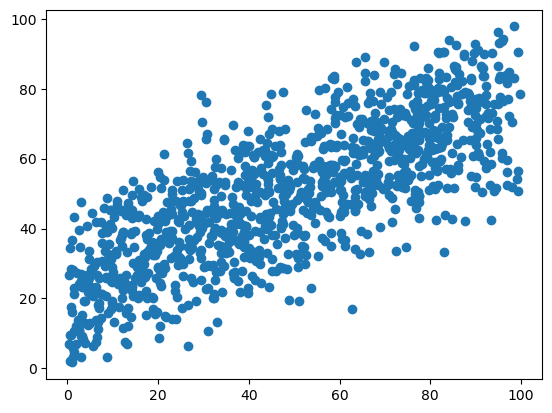

In [146]:
# Relationship of Creation score to 3&D score
plt.scatter(composite['Create'], composite['3+D'])
plt.show()

# Results

In [147]:
def abbrev_name(name):
    # abbreviate the name by taking the first letter of the first name then attaching to last name
    # Ex: "LeBron James" -> "L. James"
    name_split = name.split(' ')
    first = name_split[0]
    last = " ".join(name_split[1:])
    return f"{first[0]}. {last}"

def abbrev_name2(name):
    # abbreviate the name by taking the first two letters of the first name
    # Ex: "LeBron James" -> "Le. James"
    name_split = name.split(' ')
    first = name_split[0]
    last = " ".join(name_split[1:])
    return f"{first[:2]}. {last}"

def viz_coefs(double_lasso):
    # get the coefficient values trace
    feat_df = double_lasso.display_features()
    feat_df['abs'] = np.abs(feat_df['Coef'])
    feat_df = feat_df.sort_values('abs', ascending = False).head(10).sort_values('Coef', ascending = True)
    trace_bar = go.Bar(y = feat_df['Feature'], x = feat_df['Coef'], orientation = 'h',
                       marker = dict(color = MY_COLOR, line = dict(color = 'black', width = 1)),
                       showlegend = False)
    return trace_bar

def viz_loss(double_lasso):
    # get the loss values trace
    sets = ['Train', 'Validation', 'Test']
    loss = [double_lasso.get_loss()[s] for s in sets]
    trace = go.Bar(x = sets, y = loss, marker = dict(color = MY_COLOR, line = dict(color = 'black', width = 1)),
                   showlegend = False)
    return trace

def viz_preds(double_lasso, df, X, flip = False, abbrev_funct = abbrev_name):
    # get the predictions trace
    pred_df = double_lasso.full_predict(df, X)
    if flip:
        pred_df = pred_df.sort_values('Predicted')
    pred_df = pred_df.head(10).sort_values('Predicted', ascending = not flip)
    pred_df['Abbr_name'] = pred_df['Name'].apply(abbrev_funct)
    trace = go.Bar(y = pred_df['Abbr_name'], x = pred_df['Predicted'], orientation = 'h',
                   marker = dict(color = MY_COLOR, line = dict(color = 'black', width = 1)),
                   showlegend = False)
    return trace
    
def viz_all(model, df, df24, X, X24, stat = "", flip = False, abbrev_funct = abbrev_name):
    # visualize relevant info for one model
    # 4 plots: 1) important coefficient values, 2) loss values, 3) predictions for 2004-2023 prospects, 4) 2024 predictions
    fig = make_subplots(rows = 2, cols = 2, 
                        subplot_titles = ("Coefficients", "Loss", "Predictions (2004-2023)", "Predictions (2024)"),
                        vertical_spacing = 0.15)
    fig.add_trace(viz_coefs(model), row = 1, col = 1)
    fig.add_trace(viz_loss(model), row = 1, col = 2)
    fig.add_trace(viz_preds(model, df, X, flip, abbrev_funct), row = 2, col = 1)
    fig.add_trace(viz_preds(model, df24, X24, flip, abbrev_funct), row = 2, col = 2)
    fig.add_vline(x = 0, row = 1, col = 1)
    xlabs = ["Coefficient Value", "", f"Predicted {stat}", f"Predicted {stat}"]
    ylabs = ["Feature", "Mean Squared Error", "Player", ""]
    for i in range(4):
        r = 1 + i // 2
        c = 1 + i % 2
        fig.update_xaxes(title_text = xlabs[i], row = r, col = c)
        fig.update_yaxes(title_text = ylabs[i], row = r, col = c)
        if r == 1 and c == 1:
            max_abs = np.max(np.abs(model.display_features()['Coef']))
            fig.update_xaxes(range = [-1.05 * max_abs, 1.05 * max_abs], row = r, col = c)
        if r == 2:
            fig.update_yaxes(tickfont_size = 10, row = r, col = c)
    fig.update_layout(title = f"{stat} Model Results")
    cleanFigure(fig, size = 1000, grid = True)
    fig.update_xaxes(showgrid = True, linewidth = 1, linecolor = 'black', gridcolor = '#C0C0C0')
    fig.update_yaxes(showgrid = True, linewidth = 1, linecolor = 'black', gridcolor = '#C0C0C0')
    return fig

In [148]:
# combine all data for 2004-2023 prospects into one dataframe
draft_past = pd.concat([draft_df, recent_df]).reset_index(drop = True)
X_past = pd.concat([X, X_r]).reset_index(drop = True)

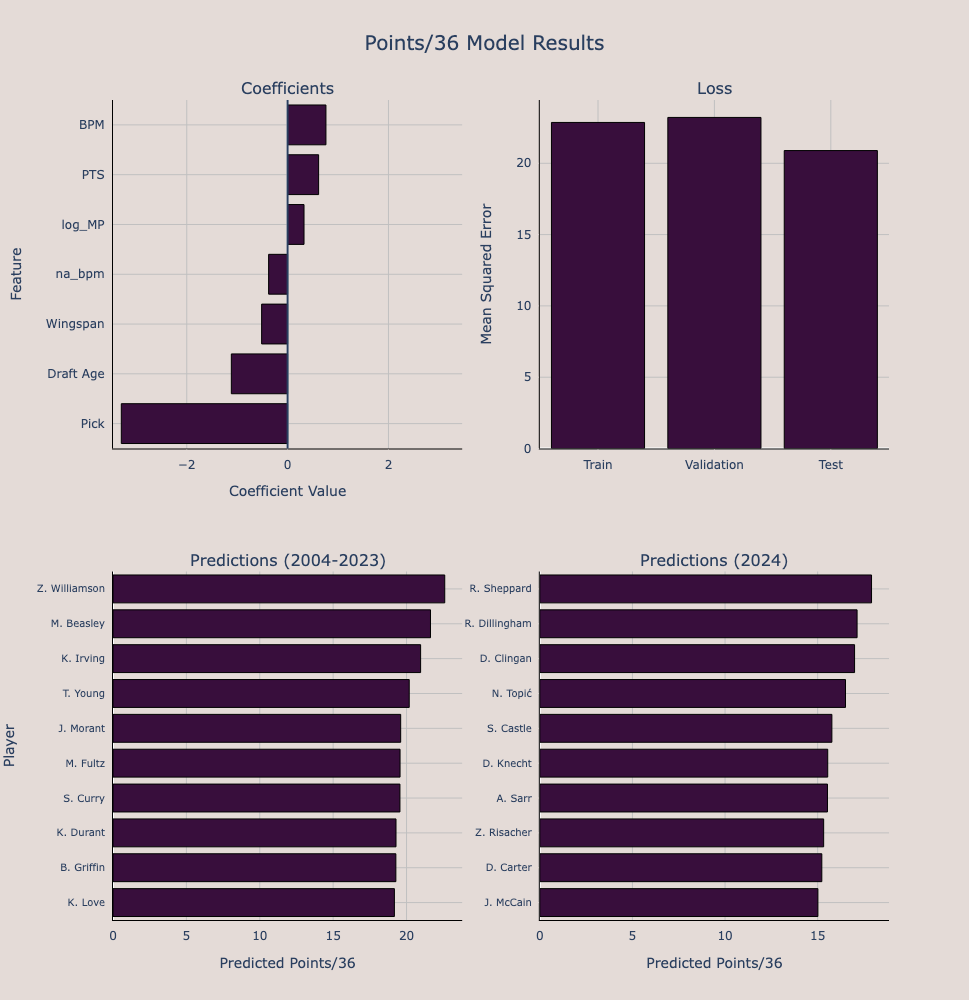

In [149]:
viz_all(pts_lasso, draft_past, draft24, X_past, X_24, "Points/36")

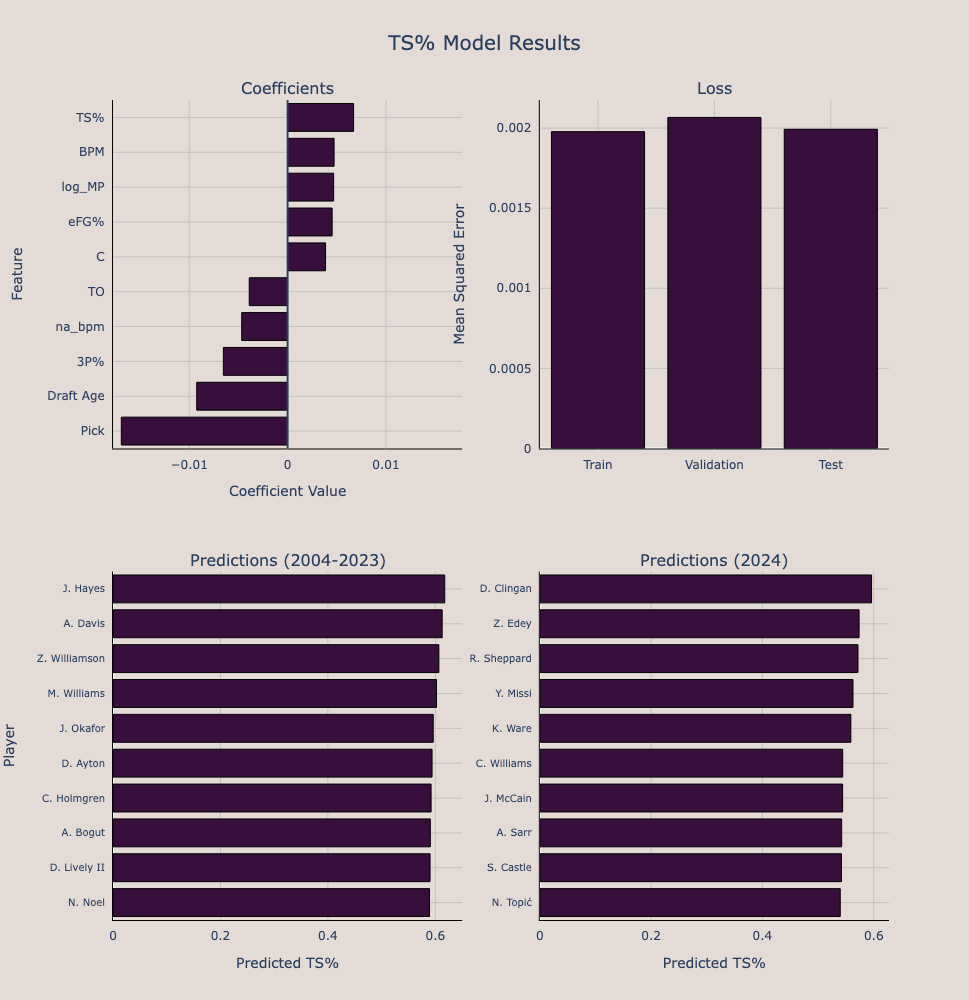

In [150]:
viz_all(tsp_lasso, draft_past, draft24, X_past, X_24, "TS%")

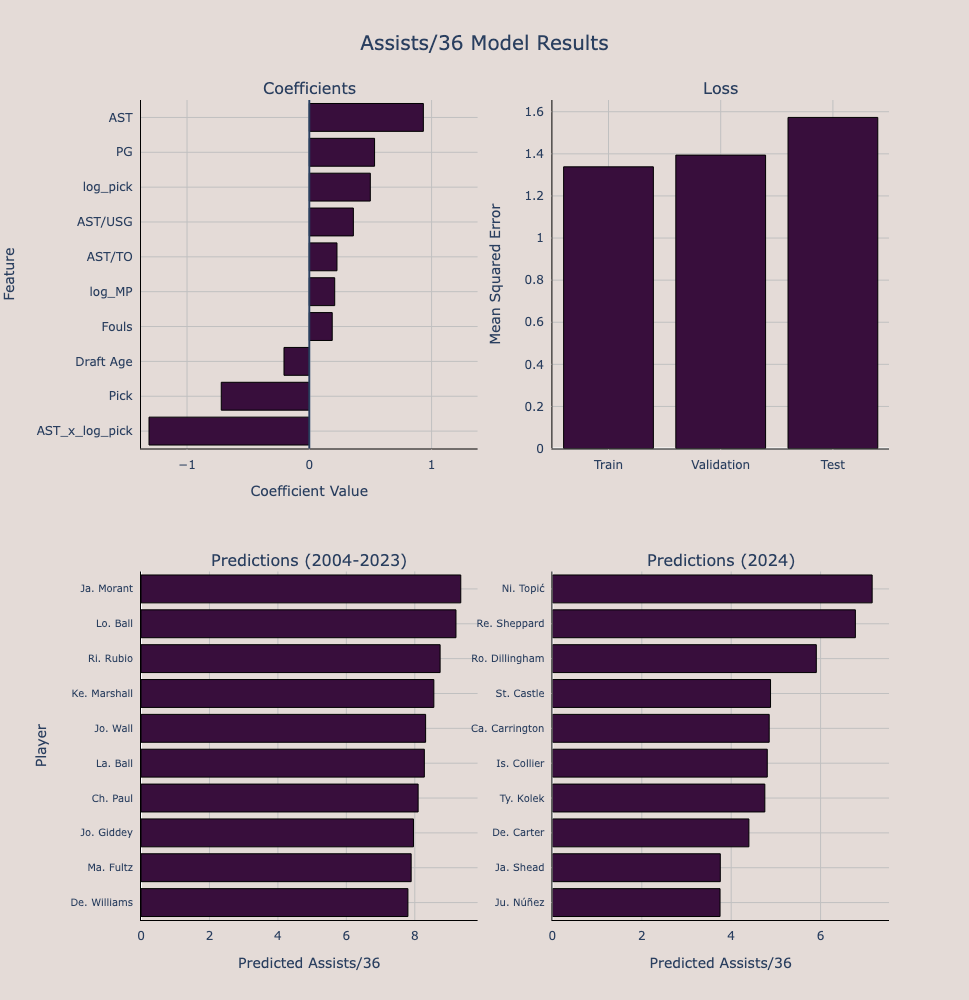

In [151]:
viz_all(ast_lasso, draft_past, draft24, X_past, X_24, "Assists/36", abbrev_funct = abbrev_name2)

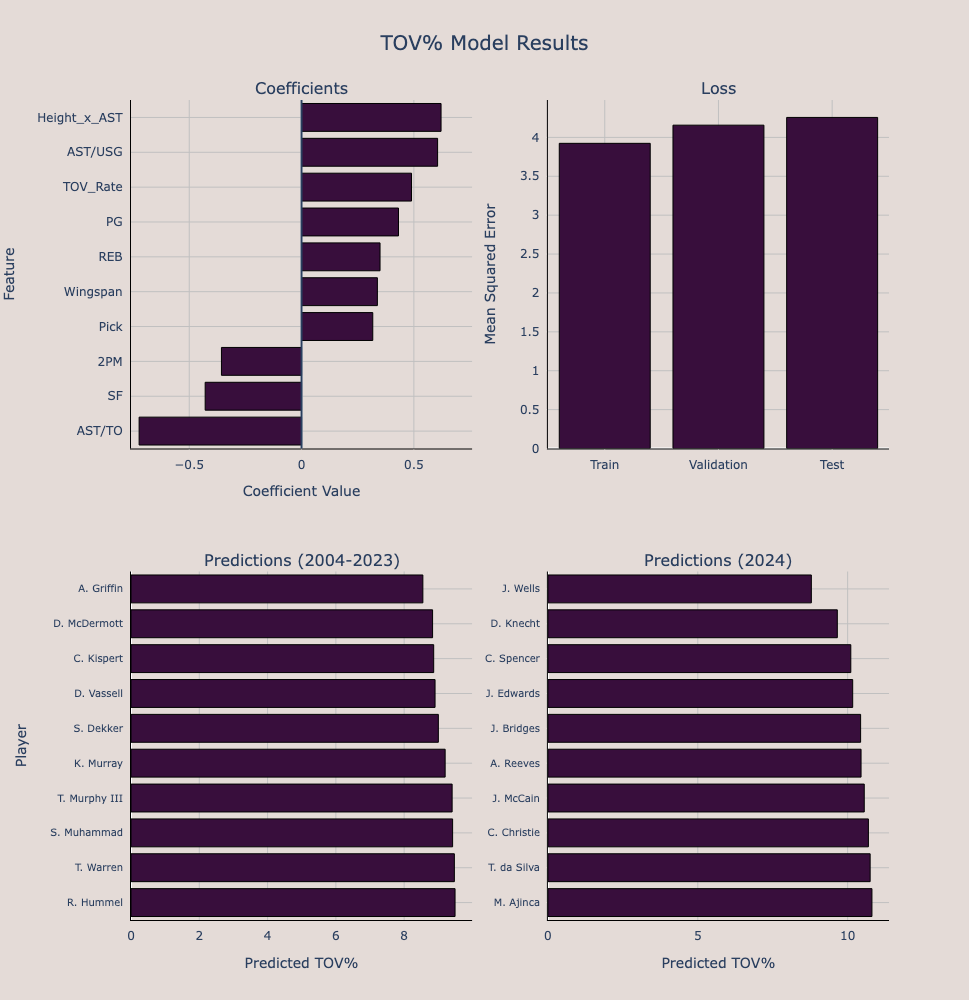

In [152]:
viz_all(tov_lasso, draft_past, draft24, X_past, X_24, "TOV%", flip = True)

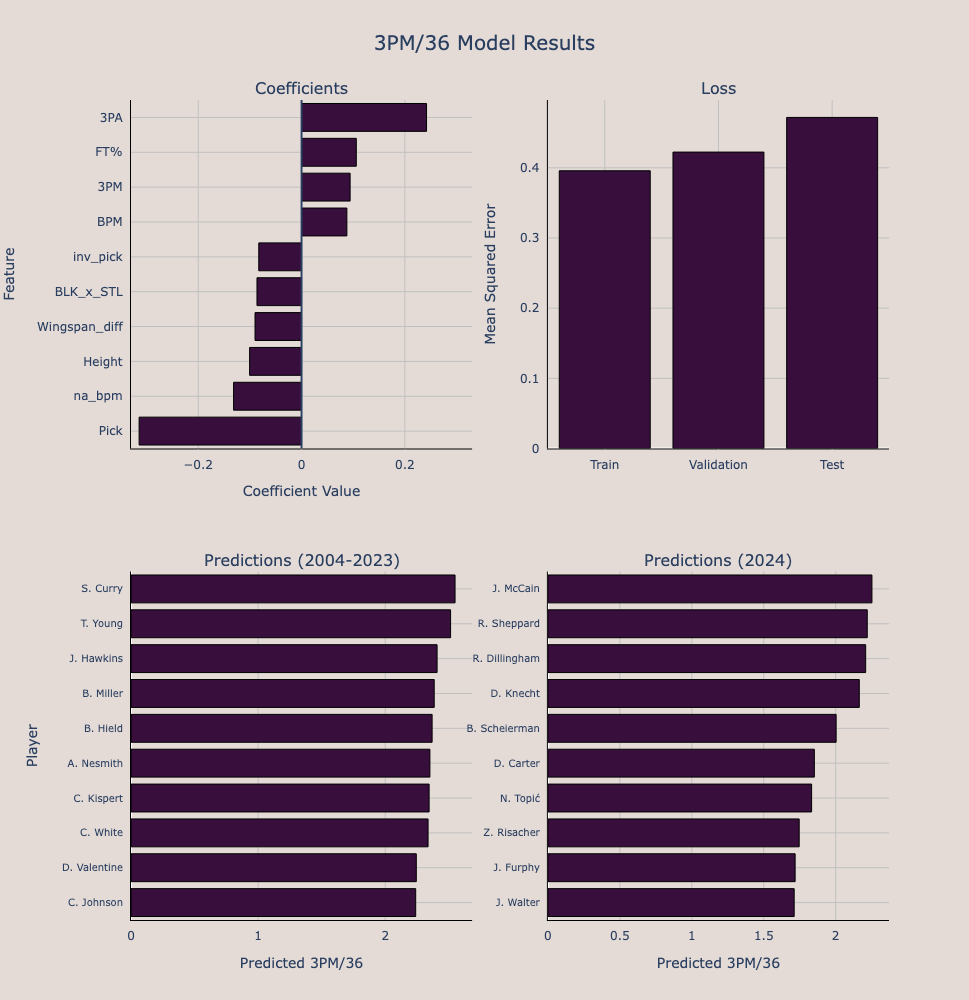

In [153]:
viz_all(tpm_lasso, draft_past, draft24, X_past, X_24, "3PM/36")

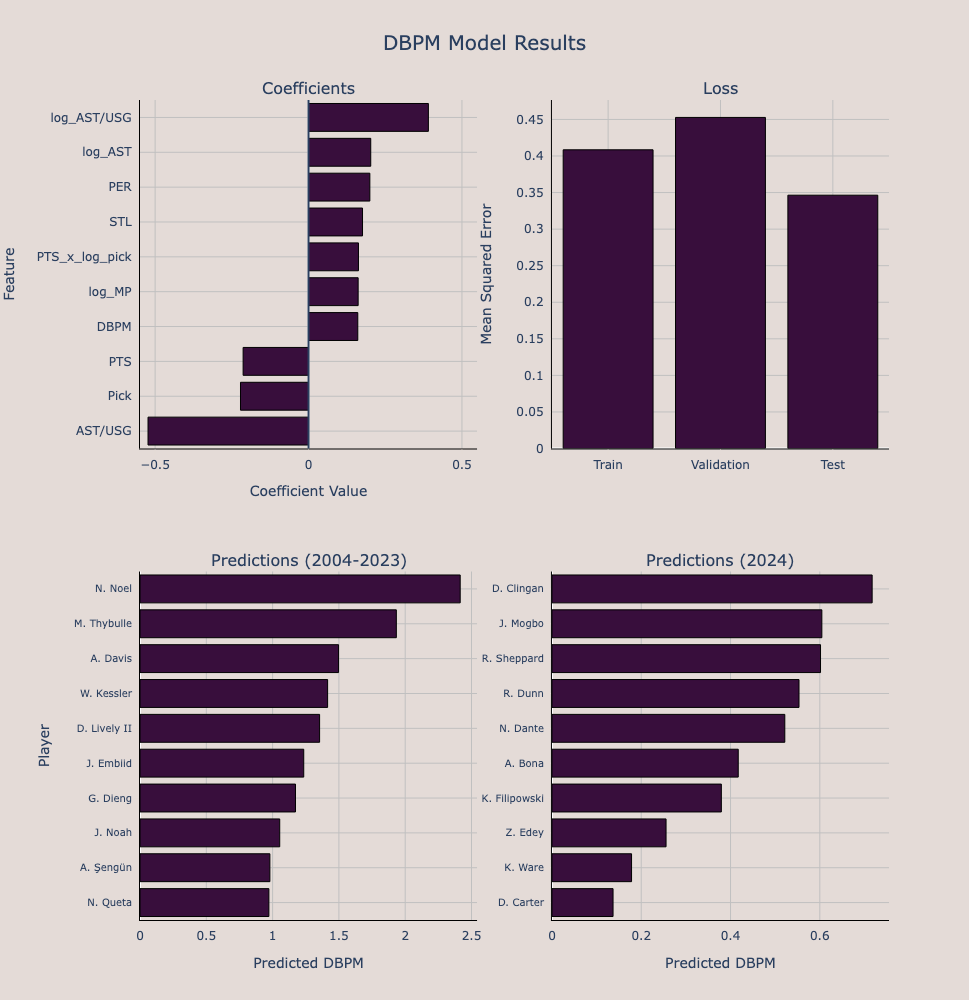

In [154]:
viz_all(def_lasso, draft_past, draft24, X_past, X_24, "DBPM")

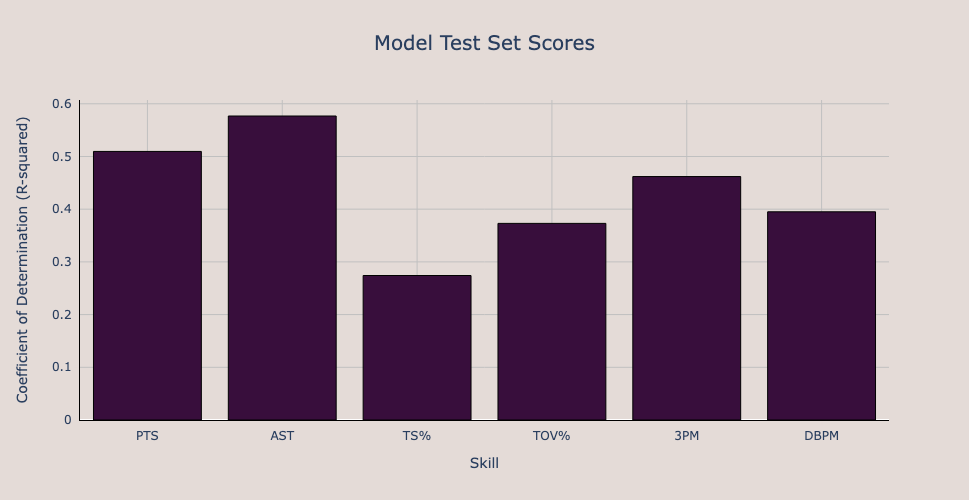

In [155]:
# get the coefficient of determination (R^2) on the test set for each model
# want to see which models are explaining a lot of variation, are more reliable
test_sets = {
    'PTS' : y_pts_test,
    'AST' : y_ast_test,
    'TS%' : y_tsp_test,
    'TOV%' : y_tov_test,
    '3PM' : y_tpm_test,
    'DBPM' : y_def_test,
}

final_scores = {sk : mod.score(X_test, test_sets[sk]) for sk, mod in final_models.items()}

trace = go.Bar(x = list(final_scores.keys()), 
               y = list(final_scores.values()), 
               marker = dict(color = MY_COLOR, 
                             line = dict(color = 'black', width = 1)),
               showlegend = False)

fig = go.Figure()
fig.add_trace(trace)
fig.update_layout(title = "Model Test Set Scores",
                  xaxis_title_text = "Skill",
                  yaxis_title_text = "Coefficient of Determination (R-squared)")
cleanFigure(fig, size = 500, grid = True)
fig